# Mount public files from GCS bucket using gcsfuse

The files used in this notebook are stored at [gs://text2mol](https://storage.cloud.google.com/text2mol)


*   embeddings
*   model evaluation results
*   training loss, validation loss and actual computation time
*   model checkpoints
*   code
*   data

Public GitHub Repository Link: https://github.com/sherrylinice/598dhl.git

Project Video Link: https://mediaspace.illinois.edu/media/t/1_zekf6gtq


In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  15238      0 --:--:-- --:--:-- --:--:-- 15194
OK
46 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: http://packages.cloud.google.com/apt/dists/gcsfuse-bionic/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 46 not upgraded.
Need to get 10.4 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 121920 files and directories currently installed.)
Preparing to unpack .../gcsfuse_2.0.1_amd64.deb ...
Unpacking gcsfuse (2.0.1) ...
Setting up gcsfuse (2.0.1) ...


In [3]:
!mkdir tar_files
!gcsfuse --implicit-dirs text2mol tar_files

{"timestamp":{"seconds":1715117271,"nanos":120088095},"severity":"INFO","message":"Start gcsfuse/2.0.1 (Go version go1.22.1) for app \"\" using mount point: /content/tar_files\n"}
{"timestamp":{"seconds":1715117271,"nanos":120338816},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"MaxRetrySleep\":30000000000,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"HttpClientTimeout\":0,\"MaxRetryDuration\":-1000000000,\"RetryMultiplier\":2,\"LocalFileCache\":false,\"TempDir\":\"\",\"ClientProtocol\":\"http1\",\"MaxConnsPerHost\":100,\"MaxIdleConnsPerHost\

## Files under the mounted folder

*   **Code**: We utilized the original authors' code to reproduce the baseline models and the ensembles (Edwards et al, 2021). Then we conducted extensive systematic ablation studies and further experiments that extend beyond the scope of the initial publication. This folder includes the complete code for this project, including both the authors' original code and our extended implementations.

*   **Model Checkpoints**: Each model checkpoint exceeds 400 MB. Due to the storage limitations imposed by Colab, we only uploaded one model checkpoint to demonstrate the training of the model. The model checkpoints for all the models trained in this project are available in the public folder: https://drive.google.com/drive/u/2/folders/1rBOlPcRzkQ-lf7qCSuWbFOT2fqc3GopY


*   **Training and Validation Embeddings**: All embeddings for all the models trained are available in this folder: https://drive.google.com/drive/u/2/folders/1mGnP54MZUGfq-sKa-XB_Yn1Uypx3Pgul


* **Model Evaluation Results**: This folder contains the results of the evaluation metrics of all the models.


* **Training and Validation Loss Data**: This folder contains the results of the training and validation losses for all the models.

# 1. Introduction

## 1.1 Background of the Problem

  * *what type of problem:* both pharmaceutical research and chemistry information retrieval tools require mapping natural language descriptions of the molecules to their corresponding molecular graphs. The lack of descriptions of the molecules and the inability to effectively retrieve the relevant molecules based on text descriptions resulted in a low utilization of the extensive molecule database available. This paper introduces Text2Mol which converts both the natural language text descriptions and the molecular graphs into embeddings and retrieves the most relevant molecules based on the natural text descriptions.

  * *what is the importance/meaning of solving the problem*: The innovative methodology proposed by the paper facilitates the translation of textual descriptions to molecules at scale. This advancement can help significantly enhance the drug discovery process in pharmaceutical research and enable a more comprehensive search of the corresponding molecules based on the natural language queries.

  * *what is the difficulty of the problem*: the challenge of the problem lies in the fact that molecular graphs and natural text descriptions have very different structures. Molecular graphs possess unique structures which make them distinct from typical linguistic formats. Aligning natural text descriptions with the corresponding molecular graphs requires first translating them into comparable linguistic dimensions.

  * *the state of the art methods and effectiveness*: two baseline models were proposed in the paper. The MLP model uses Morgan fingerprinting to convert the molecular graphs into embeddings whereas the GCN uses a graph architecture to learn the relationships between the different nodes in the molecular graphs. The effectiveness of these two models were evaluated by Mean Rank and MRR. MLP and GCN had similar results. MLP had a mean rank of 30.38 and a MRR of 0.372 on the test set while GCN had a mean rank of 42.28 and a MRR of 0.366. (Edwards et al., 2021).




## 1.2 Paper Explanation

  * *what did the paper propose*:
  
  The paper proposed Text2Mol, which requires the creation of a common semantic embedding space for molecules and textual descriptions to enable retrieval.
      - A text encoder translates natural language text descriptions into embeddings, using a pre-trained SciBERT(Beltagy et al., 2019) followed by a linear layer.
      - A molecule encoder converts molecules into embeddings.

        - The multi-layer perceptron (MLP) architecture uses Morgan fingerprinting (Rogers & Hahn, 2010) to convert the visual representation of the molecules into embeddings. These embeddings are fed into a two-layer MLP.
       - The three-layer graph convolutional network (GCN) architecture uses nodes to represent the atoms in the molecule graph and learns the relationships between the different substructures.

  The paper also implemented an ensemble approach where both the GCN and MLP architectures are incorporated.

  A transformer decoder with integrated cross-modal attention is applied:
      - Utilizing the text representation output from SciBERT as a source sequence, and the node representations from Mol2vec (Jaeger et al., 2018) GCN as a target sequence.
      - Applying a cross-modal attention between the two encoders.
      - Leveraging a symmetric contrastive loss function augmented with negative sampling for enhanced modality integration.


  * *what is the innovations of the method*: the innovation of the paper lies in the multiple techniques that were employed to improve the performance of the baseline models:
    - The ensemble method integrate the MLP and GCN architectures and capitalize on their combined strengths
    - The cross-modal attention module effectively aligns the linguistic and structural aspects of the data, and better captures the relationship between the two
    - The use of a symmetric contrastive loss function further enhances the integration of the different modals and ensures that the model balances the optimization of the text encoder and the molecule encoder


  * *how well the proposed method work (in its own metrics)*: the all ensemble approach proposed by the paper, which incorporates the ensemble of the MLP and the GCN model with cross-modal attention achieved the lowest mean rank on the test set. It reduced the mean rank from 30.38 on the MLP baseline model to 20.21. Additionally, the MRR improved from 0.372 to 0.499 (Edwards et al., 2021). The all-ensemble model also outperformed the MLP only ensemble model and the GCN only ensemble model, further proving that the all-ensemble structure effectively leverages the strengths of both the MLP and GCN models.


  * *what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem):* the techniques proposed in the paper including the ensemble approach, the cross-modal attention and the symmetric contrastive loss function substantially improved the performance of the text to molecule retrieval tasks. They improved the MRR by close to 35% compared to the MLP baseline model. This significant improvement will greatly enhance the accuracy of information retrieval tools in retrieving relevant molecular graphs based on natural text descriptions. This improved accuracy will enable a higher utilization of molecule database. It will help expedite the process of discovering the potential compounds for pharmaceutical researchers and accelerate the advancement of innovation in the pharmaceutical industry. Moreover, the ensemble approach and the cross-modal attention module are also potentially applicable in other scenarios where multiple models are employed and information from various aspects needs to be captured.


# 2. Scope of Reproducibility:

1.   Hypothesis 1: All the configurations of baseline model architectures, and the chosen hyperparameters, are required to achived optimal model performances, such that changing any of them will result in performance decline.
Dataset construction and baseline model architecture choices directly influence unifying textual and molecular modalities within a shared semantic embedding space (Edwards et al., 2021). Experiments include: ablations studies of removing normalization layers, removing hidden layers of MLP, removing convolutional layer of GCN, changing to max pooling in GCN, changing batch size to 16, adding drop out rate of 0.5, changing learning rate to 5e-5.

2.   Hypothesis 2: The ensemble approach boosts the baseline performance of the model.
Given that the GCN architecture appears to be more effective at retrieving the most difficult examples in the validation set and the MLP architecture is more effective at retrieving the most difficult examples in the test set (Edwards et al., 2021) , integrating these two architectures is expected to improve the performance of the model. Experiments include: baseline MLP and GCN models vs different combinations of MLP and GCN models ensembles, hybrid ensembles, additional experiments for exploring ensemble strategies, such as max rank, weighted rank average ensemble.

3.   Hypothesis 3: The models with the cross-modal attention layer will further improve the performance of the MLP model baseline. This enhancement is anticipated through the introduction of new association rules extracted from the attention model.
  - The cross-modal attention mechanism used in the paper only considers the ten most confident association rules between the text and the molecule, ensuring that the most important association information is captured while maintaining efficiency.

Given that the GCN architecture appears to be more effective at retrieving the most difficult examples in the validation set and the MLP architecture is more effective at retrieving the most difficult examples in the test set (Edwards et al., 2021) , integrating these two architectures is expected to improve the performance of the model.

We anticipate that the association rules extracted from the attention model will provide further insights into the relations between the text descriptions and the molecular structures. And this will translate into further improvement of the performance of the MLP baseline model.





# 3. Methodology



In [4]:
# import  packages you need
import numpy as np
from google.colab import drive
import csv
import torch
import matplotlib.pyplot as plt


## 3.1 Environment

### 3.1.1 Python Version

The python version used is 3.6.19.

### 3.1.2 Dependencies

The following packages are required: `torch` (pre-installed), `torch_geometric`, `transformers`(pre-installed), `scikit-learn`(pre-installed), and `numpy`(pre-installed).

In [6]:
!pip3 install torch_geometric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.6 MB/s eta 0:00:00


##  3.2 Data

### 3.2.1 Data Download Instructions

In this project, we utilized the ChEBI-20 dataset created by the authors for the purpose of reproducibility, accessible through their GitHub repository (Edwards, 2021). The dataset can be downloaded from the link indicated in "Download Data" section.

### 3.2.2 Data Descriptions

  #### 3.2.2.1 Source of the data
  The authors utilized data from PubChem and the Chemical Entities of Biological Interest (ChEBI) repository to construct their dataset. Specifically, they obtained 102,980 compound-description pairs by scraping compound annotations from PubChem that were derived from the ChEBI database. Subsequently, they curated a subset, consisting 33,010 compound-description pairs with description length longer than 20 words, designated as ChEBI-20. We are utilizing the ChEBI-20 (Edwards, 2021) in this project.

 #### 3.2.2.2 Data Preprocessing
The dataset provided by the author is already preprocessed. In addition, the authors did not elucidate the data preprocessing methodologies employed to derive the ChEBI-20 dataset from the original ChEBI data. Instead, they made only the processed ChEBI-20 dataset available, while indicating that the raw data from ChEBI could be accessed and downloaded.

#### 3.2.2.3 Statistics
The dataset contains 33,010 records in total of text descriptions and their corresponding molecule embeddings. The split between training, validation and test datasets are 80%/10%/10% (See output cell below). The average length of the text description is 314, with a max length of 1458 and min length of 88.

We examined the distribution of the length of the text descriptions of the molecules and the dataset skew towards longer descriptions. This is likely because longer descriptions tend to be less noisy and more informative (Edwards et al., 2021), shown in Figure 1.

In [16]:
# dir and function to load raw data
training_data = '/content/tar_files/data/training.txt'
val_data = '/content/tar_files/data/val.txt'
test_data = '/content/tar_files/data/test.txt'

def load_raw_data(raw_data_dir):
  # implement this function to load raw data to dataframe/numpy array/tensor
  descriptions = {}
  mols = {}
  training_cids = []
  with open(raw_data_dir) as f:
    reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE, fieldnames = ['cid', 'mol2vec', 'desc'])
    for n, line in enumerate(reader):
        descriptions[line['cid']] = line['desc']
        mols[line['cid']] = line['mol2vec']
        training_cids.append(line['cid'])

  return descriptions, mols

train_desc, train_mols = load_raw_data(training_data)
val_desc, val_mols = load_raw_data(val_data)
test_desc, test_mols = load_raw_data(test_data)

# calculate statistics
def calculate_stats(train_data, val_data, test_data):
  # implement this function to calculate the statistics
  # it is encouraged to print out the results
  size = len(train_data) + len(val_data) + len(test_data)
  n_classes = len(set(train_data)) + len(set(val_data)) + len(set(test_data))

  # distribution of the length of descriptions
  return size, n_classes

size, n_classes = calculate_stats(train_desc, val_desc, test_desc)
train_pct = len(train_desc)/size*100
val_pct = len(val_desc)/size*100
test_pct = len(test_desc)/size*100

data_all = {}
data_all.update(train_desc)
data_all.update(val_desc)
data_all.update(test_desc)

lengths = [len(value) for key, value in data_all.items()]


print(f"There's a total of {size} records and a total of {n_classes} distinct molecules in the dataset. \nThe split between training, validation and test datasets are {train_pct}% / {val_pct}% / {test_pct}%")
print(f"Average lengths of the text descriptions is {round(np.mean(lengths))}. \nMax length of the text descriptions is {np.max(lengths)}. \nMin length of the text descriptions is {np.min(lengths)}.")

# process raw data
# def process_data(raw_data):
#     # implement this function to process the data as you need
#   return None

# processed_data = process_data(raw_data)

# ''' you can load the processed data directly
# processed_data_dir = '/content/gdrive/My Drive/Colab Notebooks/<path-to-raw-data>'
# def load_processed_data(raw_data_dir):
#   pass

# '''

There's a total of 33010 records and a total of 33010 distinct molecules in the dataset. 
The split between training, validation and test datasets are 80.0% / 10.0% / 10.0%
Average lengths of the text descriptions is 314. 
Max length of the text descriptions is 1458. 
Min length of the text descriptions is 88.


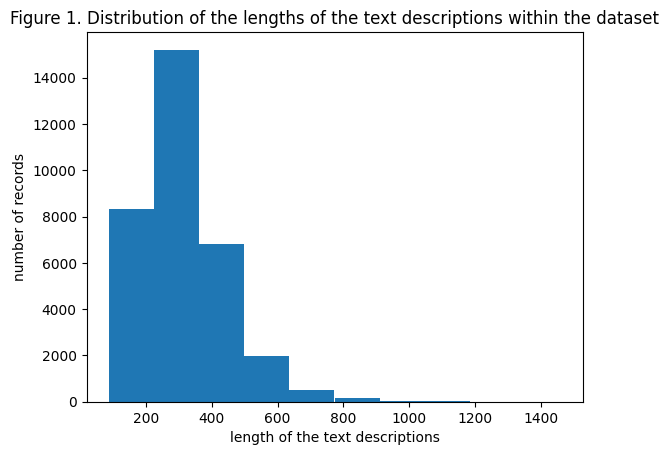

In [17]:


plt.hist(lengths);
plt.xlabel("length of the text descriptions");
plt.ylabel("number of records");
plt.title("Figure 1. Distribution of the lengths of the text descriptions within the dataset");

#### 3.2.2.4 Sample Raw Data

  We also sampled the raw data. The following shows the textual description of Glutaric Acid.

In [18]:
print(list(data_all.values())[2])

Glutaric acid is an alpha,omega-dicarboxylic acid that is a linear five-carbon dicarboxylic acid. It has a role as a human metabolite and a Daphnia magna metabolite. It is a conjugate acid of a glutarate(1-) and a glutarate.


Its corresponding molecular graph is the following:

![](https://drive.google.com/uc?id=14x__vjANi_o7RoOMCecXFDgx_WrdhcTu)

##  3.3 Models

Three models are proposed and used in the paper including the multi-layer perceptron (MLP) model,the three-layer graph convolutional network (GCN) and the cross-attention modal. Each of these models will be discussed in detail in the subsequent sections.

### 3.3.1 MLP Model
  * Model architecture:
    - layers:
      - The MLP model has one linear layer (text_hidden1) to transform the input text descriptions into embeddings before passing them through the normalization layer
      - Three linear layers are used to process the input molecule information before a normalization layer is applied
    - activation function: the model uses the ReLU activation function for the 2 linear layers for molecule information processing
  * Training objectives:
    - loss function: the model uses the symmetric contrastive loss function where it considers the output from both the text description submodel and the molecule submodel. The model is optimized towards embeddings that better capture the similarity of the text descriptions and the molecules.
    - optimizer: the model uses the Adam Optimizer
  * Others:
    - the model incorporates a pre-trained BERT-based transformer model to encode the input text descriptions into embeddings



In [19]:
class AblationOption:
  def __init__(self, normalization_layer_removal, max_pool, hidden_layer_removal, conv_layer_removal, add_dropout, change_loss, text_length_ablation):
    self.normalization_layer_removal = normalization_layer_removal
    self.max_pool = max_pool
    self.hidden_layer_removal = hidden_layer_removal
    self.conv_layer_removal = conv_layer_removal
    self.add_dropout = add_dropout
    self.change_loss = change_loss
    self.text_length_ablation = text_length_ablation

In [20]:
import torch
from torch import nn
import torch.nn.functional as F

class MLPModel(nn.Module):
    def __init__(self, ninp, nout, nhid, ablation_option):
        super(MLPModel, self).__init__()

        self.text_hidden1 = nn.Linear(ninp, nout)

        self.ninp = ninp
        self.nhid = nhid
        self.nout = nout
        self.ablation_option = ablation_option

        self.mol_hidden1 = nn.Linear(nout, nhid)

        # Ablation study: Reducing the number of hidden layers of the molecule encoder.
        if not ablation_option.hidden_layer_removal:
            self.mol_hidden2 = nn.Linear(nhid, nhid)

        self.mol_hidden3 = nn.Linear(nhid, nout)


        self.temp = nn.Parameter(torch.Tensor([0.07]))
        self.register_parameter( 'temp' , self.temp )

        # Ablation study: adding dropout.
        if ablation_option.add_dropout:
            self.dropout = nn.Dropout(0.5)

        # Ablation Study: Layer Normalization Removal.
        if not ablation_option.normalization_layer_removal:
            self.ln1 = nn.LayerNorm((nout))
            self.ln2 = nn.LayerNorm((nout))

        self.relu = nn.ReLU()
        self.selu = nn.SELU()

        self.other_params = list(self.parameters()) #get all but bert params

        self.text_transformer_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.text_transformer_model.train()

    def forward(self, text, molecule, text_mask = None):

        text_encoder_output = self.text_transformer_model(text, attention_mask = text_mask)

        text_x = text_encoder_output['pooler_output']

        text_x = self.text_hidden1(text_x)

        x = self.relu(self.mol_hidden1(molecule))

        # Ablation study: adding dropout.
        if self.ablation_option.add_dropout:
            x = self.dropout(x)

        # Ablation study: Reducing the number of hidden layers of the molecule encoder.
        if not self.ablation_option.hidden_layer_removal:
            x = self.relu(self.mol_hidden2(x))

        x = self.mol_hidden3(x)

        # Ablation Study: Layer Normalization Removal.
        if not self.ablation_option.normalization_layer_removal:
            x = self.ln1(x)
            text_x = self.ln2(text_x)


        x = x * torch.exp(self.temp)
        text_x = text_x * torch.exp(self.temp)

        return text_x, x

### 3.3.2 GCN Model
  * Model architecture:
    - layers:
      - The GCN model has one linear layer (text_hidden1) to transform the input text descriptions into embeddings before passing them through the normalization layer
     - Three Graph Convolutional Network (GCN) layers are used to generate the node embeddings from the graph data
      - Three linear layers are used to process the node embedding outputs from the GCN before a normalization layer is applied
    - activation function: the model uses the ReLU activation function for the 2 linear layers for molecule information processing and the layers of the GCN
  * Training objectives:
    - loss function: the model uses the symmetric contrastive loss function where it considers the output from both the text description submodel and the molecule submodel. The model is optimized towards embeddings that better capture the similarity of the text descriptions and the molecules.
    - optimizer: the model uses the Adam Optimizer
  * Others:
    - the model incorporates a pre-trained BERT-based transformer model to encode the input text descriptions into embeddings



In [21]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
# Ablation study: changing GCN global_mean_pool to global_max_pool. Add the next line.
from torch_geometric.nn import global_max_pool

class GCNModel(nn.Module):
    def __init__(self, num_node_features, ninp, nout, nhid, graph_hidden_channels,ablation_option):
        super(GCNModel, self).__init__()


        self.text_hidden1 = nn.Linear(ninp, nout)

        self.ninp = ninp
        self.nhid = nhid
        self.nout = nout
        self.ablation_option = ablation_option

        self.temp = nn.Parameter(torch.Tensor([0.07]))
        self.register_parameter( 'temp' , self.temp )

        self.ln1 = nn.LayerNorm((nout))
        self.ln2 = nn.LayerNorm((nout))

        self.relu = nn.ReLU()
        self.selu = nn.SELU()

        #For GCN:
        self.conv1 = GCNConv(num_node_features, graph_hidden_channels)

        # Ablation study: removing one convolutional layer.
        if not ablation_option.conv_layer_removal:
            self.conv2 = GCNConv(graph_hidden_channels, graph_hidden_channels)

        self.conv3 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.mol_hidden1 = nn.Linear(graph_hidden_channels, nhid)

        self.mol_hidden2 = nn.Linear(nhid, nhid)
        self.mol_hidden3 = nn.Linear(nhid, nout)


        self.other_params = list(self.parameters()) #get all but bert params

        self.text_transformer_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.text_transformer_model.train()

    def forward(self, text, graph_batch, text_mask = None, molecule_mask = None):

        text_encoder_output = self.text_transformer_model(text, attention_mask = text_mask)

        text_x = text_encoder_output['pooler_output']
        text_x = self.text_hidden1(text_x)


        #Obtain node embeddings
        x = graph_batch.x
        edge_index = graph_batch.edge_index
        batch = graph_batch.batch
        x = self.conv1(x, edge_index)
        x = x.relu()

        # Ablation study: Removing one convolutional layer.
        if not self.ablation_option.conv_layer_removal:
            x = self.conv2(x, edge_index)
            x = x.relu()


        x = self.conv3(x, edge_index)

        # Ablation study: changing global_mean_pool to global_max_pool.
        # Readout layer
        if not self.ablation_option.max_pool:
            x = global_mean_pool(x, batch)  # [batch_size, graph_hidden_channels]
        else:
            x = global_max_pool(x, batch)

        x = self.mol_hidden1(x).relu()
        x = self.mol_hidden2(x).relu()
        x = self.mol_hidden3(x)


        x = self.ln1(x)
        text_x = self.ln2(text_x)

        x = x * torch.exp(self.temp)
        text_x = text_x * torch.exp(self.temp)

        return text_x, x


The training time for the GCN model is significantly longer than the MLP model. We will not be demonstrating the training process in the notebook due to the runtime limits. All model checkpoints are available in the public shared folder.

###3.2.3 Attention Layer
  * Model architecture:
    - layers:
      - The Attention model has two linear layers to transform the input text descriptions into embeddings before passing them through the normalization layer
     - Three Graph Convolutional Network (GCN) layers are used to generate the node embeddings from the graph data
      - Two linear layers are used to process the node embedding outputs from the GCN before a normalization layer is applied
     - A Transformer decoder with three layers. The decoder applies text to text attention to capture the relevant information within the text embeddings.
    - activation function: the model uses the ReLU activation function for one linear layer for molecule information processing and the layers of the GCN. tanh is used as the activation function for the output of “text_hidden1” layer
  * Training objectives:
    - loss function: the model uses the symmetric contrastive loss function with negative sampling. The contrastive loss function considers the output from both the text description submodel and the molecule submodel. Negative sampling is used to minimize information leakage
    - optimizer: the model uses the Adam Optimizer
  * Others:
    - the model incorporates a pre-trained BERT-based transformer model to encode the input text descriptions into embeddings


In [22]:
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from transformers import BertTokenizerFast, BertModel

class AttentionModel(nn.Module):
  # (Edwards, 2021).
    def __init__(self, num_node_features, ninp, nout, nhid, nhead, nlayers, graph_hidden_channels, mol_trunc_length, temp, dropout=0.5):
        super(AttentionModel, self).__init__()

        self.text_hidden1 = nn.Linear(ninp, nhid)
        self.text_hidden2 = nn.Linear(nhid, nout)

        self.ninp = ninp
        self.nhid = nhid
        self.nout = nout
        self.num_node_features = num_node_features
        self.graph_hidden_channels = graph_hidden_channels
        self.mol_trunc_length = mol_trunc_length

        self.drop = nn.Dropout(p=dropout)

        decoder_layers = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        self.text_transformer_decoder = TransformerDecoder(decoder_layers, nlayers)


        self.temp = nn.Parameter(torch.Tensor([temp]))
        self.register_parameter( 'temp' , self.temp )

        self.ln1 = nn.LayerNorm((nout))
        self.ln2 = nn.LayerNorm((nout))

        self.relu = nn.ReLU()
        self.selu = nn.SELU()

        #For GCN:
        self.conv1 = GCNConv(self.num_node_features, graph_hidden_channels)
        self.conv2 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.conv3 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.mol_hidden1 = nn.Linear(graph_hidden_channels, nhid)
        self.mol_hidden2 = nn.Linear(nhid, nout)


        self.other_params = list(self.parameters()) #get all but bert params

        self.text_transformer_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.text_transformer_model.train()

        self.device = 'cpu'

    def set_device(self, dev):
        self.to(dev)
        self.device = dev

    def forward(self, text, graph_batch, text_mask = None, molecule_mask = None):

        text_encoder_output = self.text_transformer_model(text, attention_mask = text_mask)

        #Obtain node embeddings
        x = graph_batch.x
        edge_index = graph_batch.edge_index
        batch = graph_batch.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        mol_x = self.conv3(x, edge_index)

        #turn pytorch geometric output into the correct format for transformer
        #requires recovering the nodes from each graph into a separate dimension
        node_features = torch.zeros((graph_batch.num_graphs, self.mol_trunc_length, self.graph_hidden_channels)).to(self.device)
        for i, p in enumerate(graph_batch.ptr):
          if p == 0:
            old_p = p
            continue
          node_features[i - 1, :p-old_p, :] = mol_x[old_p:torch.min(p, old_p + self.mol_trunc_length), :]
          old_p = p
        node_features = torch.transpose(node_features, 0, 1)

        text_output = self.text_transformer_decoder(text_encoder_output['last_hidden_state'].transpose(0,1), node_features,
                                                            tgt_key_padding_mask = text_mask == 0, memory_key_padding_mask = ~molecule_mask)


        #Readout layer
        x = global_mean_pool(mol_x, batch)  # [batch_size, graph_hidden_channels]

        x = self.mol_hidden1(x)
        x = x.relu()
        x = self.mol_hidden2(x)

        text_x = torch.tanh(self.text_hidden1(text_output[0,:,:])) #[CLS] pooler
        text_x = self.text_hidden2(text_x)

        x = self.ln1(x)
        text_x = self.ln2(text_x)

        x = x * torch.exp(self.temp)
        text_x = text_x * torch.exp(self.temp)

        return text_x, x


The training time for the Attention model is significantly longer than the MLP model. We will not be demonstrating the training process in the notebook due to the runtime limits. All the model checkpoints are available in the public shared folder.

## 3.4 Training

### 3.4.1 Hyperparameters

* Learning Rate : 1e-4
* Batch size : 32
* Hidden layers: 3(MLP), 3(GCN)
* Drop out: None.

### 3.4.2 Computational Requirements

* Total number of trials : 6 runs of baseline models, 7 runs of ablation studies, 13 runs of ensembles, 2 runs of additional experiments (ensemble strategy exploration).
* Number of epoch per trial : 40
* Hardware: All the experiments were run on the Campus Cluster, with one GPU (Nvidia A5000), 4 CPUs per task, and memory of 32GB.   
* Actural computational time for each baseline MLP and GCN model is shown in Table 1.

In [23]:
def ReadModelTrainingLog(filename):
    res = pd.read_csv(filename)
    return res

In [24]:
import pandas as pd
from IPython.display import display, HTML

def GenerateLogTable(model_log_file_map):
    table = None
    for model_name, file_name in model_log_file_map.items():
        res = ReadModelTrainingLog(file_name)

        train_time = res['Train Time'].sum()
        valid_time = res['Valid Time'].sum()

        row = pd.DataFrame({
                'Model': [model_name],
                'Train time': [train_time],
                'Valid time': [valid_time],
            })

        if table is None:
            table = row
        else:
            table = pd.concat([table, row])
    return table

In [25]:
model_log_filenames = {
    'MLP1': '/content/tar_files/training loss_validation loss_computation_time/mlp1.csv',
    'MLP2': '/content/tar_files/training loss_validation loss_computation_time/mlp2.csv',
    'MLP3': '/content/tar_files/training loss_validation loss_computation_time/mlp3.csv',
    'GCN1': '/content/tar_files/training loss_validation loss_computation_time/gcn1.csv',
    'GCN2': '/content/tar_files/training loss_validation loss_computation_time/gcn2.csv',
    'GCN3': '/content/tar_files/training loss_validation loss_computation_time/gcn3.csv',

}

log_table = GenerateLogTable(model_log_filenames)
display(HTML('<h3>Table 1. Actural Model Training and Validation Time (ms) </h3>'))
log_table

,Model,Train time,Valid time
0,MLP1,12554.089211,597.382976
0,MLP2,12669.901670,616.165603
0,MLP3,12691.942517,621.945207
0,GCN1,26312.828763,1865.489668
0,GCN2,25885.429670,1835.201016
0,GCN3,26866.976737,1951.052202


### 3.4.3 Training code

#### 3.4.3.1 Losses

In [26]:
# from torch import nn
# import torch

# CE = nn.CrossEntropyLoss()

# def naive_loss(v1, v2):
#   logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
#   labels = torch.arange(logits.shape[0], device=v1.device)
#   return CE(logits, labels)

# def contrastive_loss(v1, v2):
#   logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
#   labels = torch.arange(logits.shape[0], device=v1.device)
#   return CE(logits, labels) + CE(torch.transpose(logits, 0, 1), labels)

# BCEL = nn.BCEWithLogitsLoss()

# def negative_sampling_contrastive_loss(v1, v2, labels):
#   logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
#   eye = torch.diag_embed(labels).to(v1.device)
#   return BCEL(logits, eye) + BCEL(torch.transpose(logits, 0, 1), eye), logits.diag() > 0

#### 3.4.3.2 Dataloaders

In [27]:
# import numpy as np
# import csv
# import shutil
# import os
# import os.path as osp
# import zipfile
# import random

# from transformers import BertTokenizerFast, BertModel

# import torch
# from torch.utils.data import Dataset, DataLoader, RandomSampler

# from torch_geometric.data import Dataset as GeoDataset
# from torch_geometric.data import DataLoader as GeoDataLoader
# from torch_geometric.data import Data, Batch


# #Need a special generator for random sampling:

# class GenerateData():
#   def __init__(self, text_trunc_length, path_train, path_val, path_test, path_molecules, path_token_embs):
#     self.path_train = path_train
#     self.path_val = path_val
#     self.path_test = path_test
#     self.path_molecules = path_molecules
#     self.path_token_embs = path_token_embs

#     self.text_trunc_length = text_trunc_length

#     self.prep_text_tokenizer()

#     if path_molecules is not None:
#       self.load_substructures()


#     self.store_descriptions()

#   def load_substructures(self):
#     self.molecule_sentences = {}
#     self.molecule_tokens = {}

#     total_tokens = set()
#     self.max_mol_length = 0
#     with open(self.path_molecules) as f:
#       for line in f:
#         spl = line.split(":")
#         cid = spl[0]
#         tokens = spl[1].strip()
#         self.molecule_sentences[cid] = tokens
#         t = tokens.split()
#         total_tokens.update(t)
#         size = len(t)
#         if size > self.max_mol_length: self.max_mol_length = size


#     self.token_embs = np.load(self.path_token_embs, allow_pickle = True)[()]



#   def prep_text_tokenizer(self):
#     self.text_tokenizer = BertTokenizerFast.from_pretrained("allenai/scibert_scivocab_uncased")


#   def store_descriptions(self):
#     self.descriptions = {}

#     self.mols = {}



#     self.training_cids = []
#     #get training set cids...
#     with open(self.path_train) as f:
#       reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE, fieldnames = ['cid', 'mol2vec', 'desc'])
#       for n, line in enumerate(reader):
#         self.descriptions[line['cid']] = line['desc']
#         self.mols[line['cid']] = line['mol2vec']
#         self.training_cids.append(line['cid'])
#     # sample 50% from the training_cids
#     #random.seed(0)
#     #self.training_cids_sample  = random.sample(self.training_cids, int(len(self.training_cids)/2))
#     self.training_cids_sample = self.training_cids

#     self.validation_cids = []
#     #get validation set cids...
#     with open(self.path_val) as f:
#       reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE, fieldnames = ['cid', 'mol2vec', 'desc'])
#       for n, line in enumerate(reader):
#         self.descriptions[line['cid']] = line['desc']
#         self.mols[line['cid']] = line['mol2vec']
#         self.validation_cids.append(line['cid'])

#     #self.validation_cids_sample  = random.sample(self.validation_cids, int(len(self.validation_cids)/2))
#     self.validation_cids_sample = self.validation_cids

#     self.test_cids = []
#     #get test set cids...
#     with open(self.path_test) as f:
#       reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE, fieldnames = ['cid', 'mol2vec', 'desc'])
#       for n, line in enumerate(reader):
#         self.descriptions[line['cid']] = line['desc']
#         self.mols[line['cid']] = line['mol2vec']
#         self.test_cids.append(line['cid'])

#     # self.test_cids_sample  = random.sample(self.test_cids, int(len(self.test_cids)/2))

#     self.test_cids_sample  = self.test_cids


#   def generate_examples_train(self):

#     np.random.shuffle(self.training_cids)
#     # np.random.shuffle(self.training_cids_sample)

#     for cid in self.training_cids:
#     # for cid in self.training_cids_sample:
#       text_input = self.text_tokenizer(self.descriptions[cid], truncation=True, max_length=self.text_trunc_length,
#                                         padding='max_length', return_tensors = 'np')

#       yield {
#           'cid': cid,
#           'input': {
#               'text': {
#                 'input_ids': text_input['input_ids'].squeeze(),
#                 'attention_mask': text_input['attention_mask'].squeeze(),
#               },
#               'molecule' : {
#                     'mol2vec' : np.fromstring(self.mols[cid], sep = " "),
#                     'cid' : cid
#               },
#           },
#       }


#   def generate_examples_val(self):

#     np.random.shuffle(self.validation_cids)
#     # np.random.shuffle(self.validation_cids_sample)

#     for cid in self.validation_cids:
#     # for cid in self.validation_cids_sample:
#         text_input = self.text_tokenizer(self.descriptions[cid], truncation=True, padding = 'max_length',
#                                          max_length=self.text_trunc_length, return_tensors = 'np')

#         mol_input = []

#         yield {
#             'cid': cid,
#             'input': {
#                 'text': {
#                   'input_ids': text_input['input_ids'].squeeze(),
#                   'attention_mask': text_input['attention_mask'].squeeze(),
#                 },
#                 'molecule' : {
#                     'mol2vec' : np.fromstring(self.mols[cid], sep = " "),
#                     'cid' : cid
#                 }
#             },
#         }


#   def generate_examples_test(self):

#     np.random.shuffle(self.test_cids)
#     # np.random.shuffle(self.test_cids_sample)

#     for cid in self.test_cids:
#     # for cid in self.test_cids_sample:
#         text_input = self.text_tokenizer(self.descriptions[cid], truncation=True, padding = 'max_length',
#                                          max_length=self.text_trunc_length, return_tensors = 'np')

#         mol_input = []

#         yield {
#             'cid': cid,
#             'input': {
#                 'text': {
#                   'input_ids': text_input['input_ids'].squeeze(),
#                   'attention_mask': text_input['attention_mask'].squeeze(),
#                 },
#                 'molecule' : {
#                     'mol2vec' : np.fromstring(self.mols[cid], sep = " "),
#                     'cid' : cid
#                 }
#             },
#         }





# class MolDataset(Dataset):
#   'PyTorch dataset for MLP version of model'
#   def __init__(self, gen, length):
#       'Initialization'

#       self.gen = gen
#       self.it = iter(self.gen())

#       self.length = length

#   def __len__(self):
#       'Denotes the total number of samples'
#       return self.length


#   def __getitem__(self, index):
#       'Generates one sample of data'

#       try:
#         ex = next(self.it)
#       except StopIteration:
#         self.it = iter(self.gen())
#         ex = next(self.it)

#       X = ex['input']
#       y = 1

#       return X, y



# def get_dataloader(data_generator, params):

#     # training_set = MolDataset(data_generator.generate_examples_train, len(data_generator.training_cids))
#     training_set = MolDataset(data_generator.generate_examples_train, len(data_generator.training_cids))
#     validation_set = MolDataset(data_generator.generate_examples_val, len(data_generator.validation_cids))
#     test_set = MolDataset(data_generator.generate_examples_test, len(data_generator.test_cids))


#     # train_sampler = RandomSampler(training_set, num_samples = int(training_set.__len__()/2))
#     # validation_sampler = RandomSampler(validation_set, num_samples = int(validation_set.__len__()/2))

#     training_generator = DataLoader(training_set,
#                                     # sampler = train_sampler,
#                                     **params)
#     validation_generator = DataLoader(validation_set,
#                                       # sampler = validation_sampler,
#                                       **params)
#     test_generator = DataLoader(test_set, **params)


#     return training_generator, validation_generator, test_generator



# class MoleculeGraphDataset(GeoDataset):
#     def __init__(self, root, cids, data_path, gt, transform=None, pre_transform=None):
#         self.cids = cids
#         self.data_path = data_path
#         self.gt = gt
#         super(MoleculeGraphDataset, self).__init__(root, transform, pre_transform)

#         self.idx_to_cid = {}
#         i = 0
#         for raw_path in self.raw_paths:
#             cid = int(raw_path.split('/')[-1][:-6])
#             self.idx_to_cid[i] = cid
#             i += 1

##     @property
#     def raw_file_names(self):
#         return [cid + ".graph" for cid in self.cids]

##     @property
#     def processed_file_names(self):
#         return ['data_{}.pt'.format(cid) for cid in self.cids]

#     def download(self):
#         # Download to `self.raw_dir`.
#         print(self.raw_dir)
#         print(osp.join(self.raw_dir, "mol_graphs.zip"))
#         print(osp.exists(osp.join(self.raw_dir, "mol_graphs.zip")))
#         if not osp.exists(osp.join(self.raw_dir, "mol_graphs.zip")):
#             shutil.copy(self.data_path, os.path.join(self.raw_dir, "mol_graphs.zip"))

#     def process_graph(self, raw_path):
#       edge_index  = []
#       x = []
#       with open(raw_path, 'r') as f:
#         next(f)
#         for line in f: #edges
#           if line != "\n":
#             edge = *map(int, line.split()),
#             edge_index.append(edge)
#           else:
#             break
#         next(f)
#         for line in f: #get mol2vec features:
#           substruct_id = line.strip().split()[-1]
#           if substruct_id in self.gt.token_embs:
#             x.append(self.gt.token_embs[substruct_id])
#           else:
#             x.append(self.gt.token_embs['UNK'])

#         return torch.LongTensor(edge_index).T, torch.FloatTensor(x)



#     def process(self):

#         with zipfile.ZipFile(osp.join(self.raw_dir, "mol_graphs.zip"), 'r') as zip_ref:
#             zip_ref.extractall(self.raw_dir)


#         i = 0
#         for raw_path in self.raw_paths:
#             # Read data from `raw_path`.

#             cid = int(raw_path.split('/')[-1][:-6])

#             edge_index, x = self.process_graph(raw_path)
#             data = Data(x=x, edge_index = edge_index)

#             if self.pre_filter is not None and not self.pre_filter(data):
#                 continue

#             if self.pre_transform is not None:
#                 data = self.pre_transform(data)

#             torch.save(data, osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
#             i += 1

#     def len(self):
#         return len(self.processed_file_names)

#     def get(self, idx):
#         data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(self.idx_to_cid[idx])))
#         return data

#     def get_cid(self, cid):
#         data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
#         return data

# #To get specific lists...

# class CustomGraphCollater(object):
#     def __init__(self, dataset, follow_batch = [], exclude_keys = []):
#         self.follow_batch = follow_batch
#         self.exclude_keys = exclude_keys
#         self.dataset = dataset

#     def collate(self, batch):
#         elem = batch[0]
#         if isinstance(elem, Data):
#             return Batch.from_data_list(batch)

#         raise TypeError('DataLoader found invalid type: {}'.format(type(elem)))

#     def __call__(self, cids):

#         return self.collate([self.dataset.get_cid(int(cid)) for cid in cids])



# def get_graph_data(data_generator, graph_data_path):
#     root = osp.join(graph_data_path[:-len(osp.basename(graph_data_path))], 'graph-data/')
#     #graph_data_path = "input/mol_graphs.zip"
#     if not os.path.exists(root):
#         os.mkdir(root)

#     mg_data_tr = MoleculeGraphDataset(root, data_generator.training_cids, graph_data_path, data_generator)
#     graph_batcher_tr = CustomGraphCollater(mg_data_tr)

#     mg_data_val = MoleculeGraphDataset(root, data_generator.validation_cids, graph_data_path, data_generator)
#     graph_batcher_val = CustomGraphCollater(mg_data_val)

#     mg_data_test = MoleculeGraphDataset(root, data_generator.test_cids, graph_data_path, data_generator)
#     graph_batcher_test = CustomGraphCollater(mg_data_test)

#     return graph_batcher_tr, graph_batcher_val, graph_batcher_test




# #Loaders for attention association rule models


# class GenerateDataAttention():
#   def __init__(self, text_trunc_length, path_train, path_val, path_test, path_molecules, path_token_embs):
#     self.path_train = path_train
#     self.path_val = path_val
#     self.path_test = path_test
#     self.path_molecules = path_molecules
#     self.path_token_embs = path_token_embs

#     self.text_trunc_length = text_trunc_length

#     self.prep_text_tokenizer()

#     self.load_substructures()


#     self.store_descriptions()

#   def load_substructures(self):
#     self.molecule_sentences = {}
#     self.molecule_tokens = {}

#     total_tokens = set()
#     self.max_mol_length = 0
#     with open(self.path_molecules) as f:
#       for line in f:
#         spl = line.split(":")
#         cid = spl[0]
#         tokens = spl[1].strip()
#         self.molecule_sentences[cid] = tokens
#         t = tokens.split()
#         total_tokens.update(t)
#         size = len(t)
#         if size > self.max_mol_length: self.max_mol_length = size


#     self.token_embs = np.load(self.path_token_embs, allow_pickle = True)[()]



#   def prep_text_tokenizer(self):
#     self.text_tokenizer = BertTokenizerFast.from_pretrained("allenai/scibert_scivocab_uncased")


#   def store_descriptions(self):
#     self.descriptions = {}

#     self.mols = {}



#     self.training_cids = []
#     #get training set cids...
#     with open(self.path_train) as f:
#       reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE, fieldnames = ['cid', 'mol2vec', 'desc'])
#       for n, line in enumerate(reader):
#         self.descriptions[line['cid']] = line['desc']
#         self.mols[line['cid']] = line['mol2vec']
#         self.training_cids.append(line['cid'])

#     self.validation_cids = []
#     #get validation set cids...
#     with open(self.path_val) as f:
#       reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE, fieldnames = ['cid', 'mol2vec', 'desc'])
#       for n, line in enumerate(reader):
#         self.descriptions[line['cid']] = line['desc']
#         self.mols[line['cid']] = line['mol2vec']
#         self.validation_cids.append(line['cid'])

#     self.test_cids = []
#     with open(self.path_test) as f:
#       reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE, fieldnames = ['cid', 'mol2vec', 'desc'])
#       for n, line in enumerate(reader):
#         self.descriptions[line['cid']] = line['desc']
#         self.mols[line['cid']] = line['mol2vec']
#         self.test_cids.append(line['cid'])

#   #transformers can't take array with full attention so have to pad a 0...
#   def padarray(self, A, size, value=0):
#       t = size - len(A)
#       return np.pad(A, pad_width=(0, t), mode='constant', constant_values = value)


#   def generate_examples_train(self):

#     np.random.shuffle(self.training_cids)

#     for cid in self.training_cids:
#       label = np.random.randint(2)
#       rand_cid = np.random.choice(self.training_cids)
#       if label:
#         text_input = self.text_tokenizer(self.descriptions[cid], truncation=True, max_length=self.text_trunc_length - 1,
#                                         padding='max_length', return_tensors = 'np')
#       else:
#         text_input = self.text_tokenizer(self.descriptions[rand_cid], truncation=True, max_length=self.text_trunc_length - 1,
#                                         padding='max_length', return_tensors = 'np')

#       text_ids = self.padarray(text_input['input_ids'].squeeze(), self.text_trunc_length)
#       text_mask = self.padarray(text_input['attention_mask'].squeeze(), self.text_trunc_length)

#       yield {
#           'cid': cid,
#           'input': {
#               'text': {
#                 'input_ids': text_ids,
#                 'attention_mask': text_mask,
#               },
#               'molecule' : {
#                     'mol2vec' : np.fromstring(self.mols[cid], sep = " "),
#                     'cid' : cid
#               },
#           },
#           'label': label
#       }


#   def generate_examples_val(self):

#     np.random.shuffle(self.validation_cids)

#     for cid in self.validation_cids:
#       label = np.random.randint(2)
#       rand_cid = np.random.choice(self.validation_cids)
#       if label:
#         text_input = self.text_tokenizer(self.descriptions[cid], truncation=True, max_length=self.text_trunc_length - 1,
#                                         padding='max_length', return_tensors = 'np')
#       else:
#         text_input = self.text_tokenizer(self.descriptions[rand_cid], truncation=True, max_length=self.text_trunc_length - 1,
#                                         padding='max_length', return_tensors = 'np')


#       text_ids = self.padarray(text_input['input_ids'].squeeze(), self.text_trunc_length)
#       text_mask = self.padarray(text_input['attention_mask'].squeeze(), self.text_trunc_length)

#       yield {
#           'cid': cid,
#           'input': {
#               'text': {
#                 'input_ids': text_ids,
#                 'attention_mask': text_mask,
#               },
#               'molecule' : {
#                     'mol2vec' : np.fromstring(self.mols[cid], sep = " "),
#                     'cid' : cid
#               },
#           },
#           'label': label
#       }

#   def generate_examples_test(self):

#     np.random.shuffle(self.test_cids)

#     for cid in self.test_cids:
#       label = np.random.randint(2)
#       rand_cid = np.random.choice(self.test_cids)
#       if label:
#         text_input = self.text_tokenizer(self.descriptions[cid], truncation=True, max_length=self.text_trunc_length - 1,
#                                         padding='max_length', return_tensors = 'np')
#       else:
#         text_input = self.text_tokenizer(self.descriptions[rand_cid], truncation=True, max_length=self.text_trunc_length - 1,
#                                         padding='max_length', return_tensors = 'np')


#       text_ids = self.padarray(text_input['input_ids'].squeeze(), self.text_trunc_length)
#       text_mask = self.padarray(text_input['attention_mask'].squeeze(), self.text_trunc_length)

#       yield {
#           'cid': cid,
#           'input': {
#               'text': {
#                 'input_ids': text_ids,
#                 'attention_mask': text_mask,
#               },
#               'molecule' : {
#                     'mol2vec' : np.fromstring(self.mols[cid], sep = " "),
#                     'cid' : cid
#               },
#           },
#           'label': label
#       }


# class AttentionDataset(Dataset):
#   'Characterizes a dataset for PyTorch'
#   def __init__(self, gen, length):
#       'Initialization'

#       self.gen = gen
#       self.it = iter(self.gen())

#       self.length = length

#   def __len__(self):
#       'Denotes the total number of samples'
#       return self.length


#   def __getitem__(self, index):
#       'Generates one sample of data'

#       try:
#         ex = next(self.it)
#       except StopIteration:
#         self.it = iter(self.gen())
#         ex = next(self.it)

#       X = ex['input']
#       y = ex['label']

#       return X, y



# class AttentionGraphCollater(object):
#     def __init__(self, dataset, mask_len, follow_batch = [], exclude_keys = []):
#         self.follow_batch = follow_batch
#         self.exclude_keys = exclude_keys
#         self.dataset = dataset
#         self.mask_len = mask_len
#         self.mask_indices = np.array(range(mask_len))

#     def generate_mask(self, sz):
#         rv = torch.zeros((self.mask_len), dtype = torch.bool)
#         rv = rv.masked_fill(torch.BoolTensor(self.mask_indices < sz), bool(1)) #pytorch transformer input version
#         rv[-1] = 0 #set last value to 0 because pytorch can't handle all 1s
#         return rv

#     def get_masks(self, batch):
#       return torch.stack([self.generate_mask(b.x.shape[0]) for b in batch])

#     def collate(self, batch):
#         elem = batch[0]
#         if isinstance(elem, Data):
#             return Batch.from_data_list(batch)

#         raise TypeError('DataLoader found invalid type: {}'.format(type(elem)))

#     def __call__(self, cids):

#         tmp = [self.dataset.get_cid(int(cid)) for cid in cids]
#         return self.collate(tmp), self.get_masks(tmp)

# def get_attention_graph_data(data_generator, graph_data_path, mol_trunc_length):
#     root = osp.join(graph_data_path[:-len(osp.basename(graph_data_path))], 'graph-data/')
#     #graph_data_path = "input/mol_graphs.zip"
#     if not os.path.exists(root):
#         os.mkdir(root)

#     mg_data_tr = MoleculeGraphDataset(root, data_generator.training_cids, graph_data_path, data_generator)
#     graph_batcher_tr = AttentionGraphCollater(mg_data_tr, mol_trunc_length)

#     mg_data_val = MoleculeGraphDataset(root, data_generator.validation_cids, graph_data_path, data_generator)
#     graph_batcher_val = AttentionGraphCollater(mg_data_val, mol_trunc_length)

#     mg_data_test = MoleculeGraphDataset(root, data_generator.test_cids, graph_data_path, data_generator)
#     graph_batcher_test = AttentionGraphCollater(mg_data_test, mol_trunc_length)

#     return graph_batcher_tr, graph_batcher_val, graph_batcher_test


# def get_attention_dataloader(data_generator, params):


#     # random sampler implementation
#     # np.random.seed(0)
#     # torch.manual_seed(0)

#     training_set = AttentionDataset(data_generator.generate_examples_train, len(data_generator.training_cids))
#     validation_set = AttentionDataset(data_generator.generate_examples_val, len(data_generator.validation_cids))
#     test_set = AttentionDataset(data_generator.generate_examples_test, len(data_generator.test_cids))

#     # train_sampler = RandomSampler(training_set, num_samples = int(training_set.__len__()/2))
#     # validation_sampler = RandomSampler(validation_set, num_samples = int(validation_set.__len__()/2))
#     training_generator = DataLoader(training_set,
#                                     # sampler = train_sampler
#                                     **params)
#     validation_generator = DataLoader(validation_set,
#                                       # sampler = validation_sampler
#                                       **params)
#     test_generator = DataLoader(test_set, **params)


#     return training_generator, validation_generator, test_generator


#### 3.4.3.3 Training code

In [28]:

# import os
# import os.path as osp
# import shutil
# import time
# import csv
# import math
# import pickle

# import numpy as np


# import torch

# import torch.optim as optim
# from transformers.optimization import get_linear_schedule_with_warmup


# # from losses import contrastive_loss, negative_sampling_contrastive_loss
# # from models import MLPModel, GCNModel, AttentionModel
# #from dataloaders import get_dataloader, GenerateData, get_graph_data, get_attention_graph_data, GenerateDataAttention, get_attention_dataloader


# import argparse

# #from ablation_option import AblationOption

# def training():
#   parser = argparse.ArgumentParser(description='Run Text2Mol')
#   parser.add_argument('--data', metavar='data', type=str,
#                       help='directory where data is located')
#   parser.add_argument('--output_path', metavar='output_path', type=str,
#                       help='directory where data is located')
#   parser.add_argument('--model', type=str, default='MLP', nargs='?',
#                       help="model type from 'MLP, 'GCN', 'Attention'")
#   parser.add_argument('--mol_trunc_length', type=int, nargs='?', default=512,
#                       help='Molecule truncation length.')
#   parser.add_argument('--text_trunc_length', type=int, nargs='?', default=256,
#                       help='Text truncation length.')
#   parser.add_argument('--num_warmup_steps', type=int, nargs='?', default=1000,
#                       help='Number of warmup steps.')
#   parser.add_argument('--epochs', type=int, default=40,
#                       help='Number of epochs to train model.')
#   parser.add_argument('--batch_size', type=int, default=32,
#                       help='Size of data batch.')
#   parser.add_argument('--lr', type=float, nargs='?', default=1e-4,
#                       help='learning rate')
#   parser.add_argument('--bert_lr', type=float, nargs='?', default=3e-5,
#                       help='Size of data batch.')
#   parser.add_argument('--normalization_layer_removal', type=bool, nargs='?', default=False,
#                       help='True or False')
#   parser.add_argument('--max_pool', type=bool, nargs='?', default=False,
#                       help='True or False')
#   parser.add_argument('--hidden_layer_removal', type=bool, nargs='?', default=False,
#                       help='True or False')
#   parser.add_argument('--conv_layer_removal', type=bool, nargs='?', default=False,
#                       help='True or False')
#   parser.add_argument('--add_dropout', type=bool, nargs='?', default=False,
#                       help='True or False')

#   args = parser.parse_args()
#   data_path = args.data
#   output_path = args.output_path
#   MODEL = args.model

#   BATCH_SIZE = args.batch_size
#   epochs = args.epochs

#   init_lr = args.lr
#   bert_lr = args.bert_lr
#   num_warmup_steps = args.num_warmup_steps
#   text_trunc_length = args.text_trunc_length

#   mol_trunc_length = args.mol_trunc_length #attention model only


#   path_token_embs = osp.join(data_path, "token_embedding_dict.npy")
#   path_train = osp.join(data_path, "training.txt")
#   path_val = osp.join(data_path, "val.txt")
#   path_test = osp.join(data_path, "test.txt")
#   path_molecules = osp.join(data_path, "ChEBI_definitions_substructure_corpus.cp")

#   graph_data_path = osp.join(data_path, "mol_graphs.zip")

#   ablation_option = AblationOption(args.normalization_layer_removal, args.max_pool, args.hidden_layer_removal, args.conv_layer_removal, args.add_dropout)

#   if MODEL == "MLP":
#       gd = GenerateData(text_trunc_length, path_train, path_val, path_test, path_molecules, path_token_embs)

#       # Parameters
#       params = {'batch_size': BATCH_SIZE,
#               'num_workers': 4}

#       training_generator, validation_generator, test_generator = get_dataloader(gd, params)

#       model = MLPModel(ninp = 768, nhid = 600, nout = 300, ablation_option = ablation_option)

#   elif MODEL == "GCN":
#       gd = GenerateData(text_trunc_length, path_train, path_val, path_test, path_molecules, path_token_embs)

#       # Parameters
#       params = {'batch_size': BATCH_SIZE,
#               'num_workers': 4}

#       training_generator, validation_generator, test_generator = get_dataloader(gd, params)

#       graph_batcher_tr, graph_batcher_val, graph_batcher_test = get_graph_data(gd, graph_data_path)

#       model = GCNModel(num_node_features=gragh_batcher_tr.dataset.num_node_features, ninp = 768, nhid = 600, nout = 300, gragh_hidden_channels = 600, ablation_option = ablation_option)


#   elif MODEL == "Attention":
#       gd = GenerateDataAttention(text_trunc_length, path_train, path_val, path_test, path_molecules, path_token_embs)

#       # Parameters
#       params = {'batch_size': BATCH_SIZE,
#               'num_workers': 4}

#       training_generator, validation_generator, test_generator = get_attention_dataloader(gd, params)

#       graph_batcher_tr, graph_batcher_val, graph_batcher_test = get_attention_graph_data(gd, graph_data_path, mol_trunc_length)

#       model = AttentionModel(num_node_features=graph_batcher_tr.dataset.num_node_features, ninp = 768, nout = 300, nhead = 8, nhid = 512, nlayers = 3,
#           graph_hidden_channels = 768, mol_trunc_length=mol_trunc_length, temp=0.07)

#   bert_params = list(model.text_transformer_model.parameters())

#   optimizer = optim.Adam([
#                   {'params': model.other_params},
#                   {'params': bert_params, 'lr': bert_lr}
#               ], lr=init_lr)

#   num_training_steps = epochs * len(training_generator) - num_warmup_steps
#   scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = num_training_steps)


#   device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#   print(device)

#   if MODEL == "Attention":
#       tmp = model.set_device(device)
#   else:
#       tmp = model.to(device)


#   train_losses = []
#   val_losses = []

#   train_acc = []
#   val_acc = []

#   if not os.path.exists(output_path):
#     os.mkdir(output_path)

#   # Loop over epochs
#   for epoch in range(epochs):
#       # Training

#       start_time = time.time()
#       running_loss = 0.0
#       running_acc = 0.0
#       model.train()
#       for i, d in enumerate(training_generator):
#           batch, labels = d
#           # Transfer to GPU

#           text_mask = batch['text']['attention_mask'].bool()

#           text = batch['text']['input_ids'].to(device)
#           text_mask = text_mask.to(device)
#           molecule = batch['molecule']['mol2vec'].float().to(device)

#           if MODEL == "MLP":
#               text_out, chem_out = model(text, molecule, text_mask)

#               loss = contrastive_loss(text_out, chem_out).to(device)
#               running_loss += loss.item()
#           elif MODEL == "GCN":
#               graph_batch = graph_batcher_tr(d[0]['molecule']['cid']).to(device)
#               text_out, chem_out = model(text, graph_batch, text_mask)

#               loss = contrastive_loss(text_out, chem_out).to(device)
#               running_loss += loss.item()
#           elif MODEL == "Attention":
#               graph_batch, molecule_mask = graph_batcher_tr(d[0]['molecule']['cid'])
#               graph_batch = graph_batch.to(device)
#               molecule_mask = molecule_mask.to(device)
#               labels = labels.float().to(device)
#               text_out, chem_out = model(text, graph_batch, text_mask, molecule_mask)

#               loss, pred = negative_sampling_contrastive_loss(text_out, chem_out, labels)
#               if torch.isnan(loss): raise ValueError('Loss is NaN.')

#               running_loss += loss.item()
#               running_acc += np.sum((pred.squeeze().cpu().detach().numpy() > 0) == labels.cpu().detach().numpy()) / labels.shape[0]


#           running_loss += loss.item()
#           optimizer.zero_grad()
#           loss.backward()
#           optimizer.step()

#           scheduler.step()

#           if (i+1) % 100 == 0: print(i+1, "batches trained. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
#       train_losses.append(running_loss / (i+1))
#       train_acc.append(running_acc / (i+1))

#       print("Epoch", epoch+1, "training loss:\t\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")
#       print("Training Accuracy:", train_acc[-1])



#       # Validation
#       model.eval()
#       with torch.set_grad_enabled(False):
#           start_time = time.time()
#           running_loss = 0.0
#           running_acc = 0.0
#           for i, d in enumerate(validation_generator):
#               batch, labels = d
#               # Transfer to GPU

#               text_mask = batch['text']['attention_mask'].bool()

#               text = batch['text']['input_ids'].to(device)
#               text_mask = text_mask.to(device)
#               molecule = batch['molecule']['mol2vec'].float().to(device)

#               if MODEL == "MLP":
#                   text_out, chem_out = model(text, molecule, text_mask)

#                   loss = contrastive_loss(text_out, chem_out).to(device)
#                   running_loss += loss.item()
#               elif MODEL == "GCN":
#                   graph_batch = graph_batcher_val(d[0]['molecule']['cid']).to(device)
#                   text_out, chem_out = model(text, graph_batch, text_mask)

#                   loss = contrastive_loss(text_out, chem_out).to(device)
#                   running_loss += loss.item()
#               elif MODEL == "Attention":
#                   graph_batch, molecule_mask = graph_batcher_val(d[0]['molecule']['cid'])
#                   graph_batch = graph_batch.to(device)
#                   molecule_mask = molecule_mask.to(device)
#                   labels = labels.float().to(device)
#                   text_out, chem_out = model(text, graph_batch, text_mask, molecule_mask)

#                   loss, pred = negative_sampling_contrastive_loss(text_out, chem_out, labels)
#                   running_loss += loss.item()
#                   running_acc += np.sum((pred.squeeze().cpu().detach().numpy() > 0) == labels.cpu().detach().numpy()) / labels.shape[0]

#               if (i+1) % 100 == 0: print(i+1, "batches eval. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))

#           val_losses.append(running_loss / (i+1))
#           val_acc.append(running_acc / (i+1))


#           min_loss = np.min(val_losses)
#           if val_losses[-1] == min_loss:
#               torch.save(model.state_dict(), output_path + 'weights_pretrained.{epoch:02d}-{min_loss:.2f}.pt'.format(epoch = epoch+1, min_loss = min_loss))

#       print("Epoch", epoch+1, "validation loss:\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")
#       if MODEL == "Attention": print("Validation Accuracy:", val_acc[-1])


#   torch.save(model.state_dict(), output_path + "final_weights."+str(epochs)+".pt")


#   cids_train = np.array([])
#   cids_val = np.array([])
#   cids_test = np.array([])
#   chem_embeddings_train = np.array([])
#   text_embeddings_train = np.array([])
#   chem_embeddings_val = np.array([])
#   text_embeddings_val = np.array([])
#   chem_embeddings_test = np.array([])
#   text_embeddings_test = np.array([])

#   if MODEL != "Attention": #Store embeddings:
#       def get_emb(d, graph_batcher = None):
#           with torch.no_grad():
#               cid = np.array([d['cid']])
#               text_mask = torch.Tensor(d['input']['text']['attention_mask']).bool().reshape(1,-1).to(device)

#               text = torch.Tensor(d['input']['text']['input_ids']).long().reshape(1,-1).to(device)
#               molecule = torch.Tensor(d['input']['molecule']['mol2vec']).float().reshape(1,-1).to(device)

#               if MODEL == "MLP":
#                   text_emb, chem_emb = model(text, molecule, text_mask)
#               elif MODEL == "GCN":
#                   graph_batch = graph_batcher([d['input']['molecule']['cid']]).to(device)
#                   graph_batch.edge_index = graph_batch.edge_index.reshape((2,-1))
#                   text_emb, chem_emb = model(text, graph_batch, text_mask)

#               chem_emb = chem_emb.cpu().numpy()
#               text_emb = text_emb.cpu().numpy()

#           return cid, chem_emb, text_emb

#       for i, d in enumerate(gd.generate_examples_train()):

#           if MODEL == "MLP":
#               cid, chem_emb, text_emb = get_emb(d)
#           elif MODEL == "GCN":
#               cid, chem_emb, text_emb = get_emb(d, graph_batcher_tr)

#           cids_train = np.concatenate((cids_train, cid)) if cids_train.size else cid
#           chem_embeddings_train = np.concatenate((chem_embeddings_train, chem_emb)) if chem_embeddings_train.size else chem_emb
#           text_embeddings_train = np.concatenate((text_embeddings_train, text_emb)) if text_embeddings_train.size else text_emb

#           if (i+1) % 1000 == 0: print(i+1, "embeddings processed")


#       print("Training Embeddings done:", cids_train.shape, chem_embeddings_train.shape)

#       for d in gd.generate_examples_val():

#           if MODEL == "MLP":
#               cid, chem_emb, text_emb = get_emb(d)
#           elif MODEL == "GCN":
#               cid, chem_emb, text_emb = get_emb(d, graph_batcher_val)

#           cids_val = np.concatenate((cids_val, cid)) if cids_val.size else cid
#           chem_embeddings_val = np.concatenate((chem_embeddings_val, chem_emb)) if chem_embeddings_val.size else chem_emb
#           text_embeddings_val = np.concatenate((text_embeddings_val, text_emb)) if text_embeddings_val.size else text_emb

#       print("Validation Embeddings done:", cids_val.shape, chem_embeddings_val.shape)

#       for d in gd.generate_examples_test():

#           if MODEL == "MLP":
#               cid, chem_emb, text_emb = get_emb(d)
#           elif MODEL == "GCN":
#               cid, chem_emb, text_emb = get_emb(d, graph_batcher_test)

#           cids_test = np.concatenate((cids_test, cid)) if cids_test.size else cid
#           chem_embeddings_test = np.concatenate((chem_embeddings_test, chem_emb)) if chem_embeddings_test.size else chem_emb
#           text_embeddings_test = np.concatenate((text_embeddings_test, text_emb)) if text_embeddings_test.size else text_emb

#       print("Test Embeddings done:", cids_test.shape, chem_embeddings_test.shape)

#       emb_path = osp.join(output_path, "embeddings/")
#       if not os.path.exists(emb_path):
#           os.mkdir(emb_path)
#       np.save(emb_path+"cids_train.npy", cids_train)
#       np.save(emb_path+"cids_val.npy", cids_val)
#       np.save(emb_path+"cids_test.npy", cids_test)
#       np.save(emb_path+"chem_embeddings_train.npy", chem_embeddings_train)
#       np.save(emb_path+"chem_embeddings_val.npy", chem_embeddings_val)
#       np.save(emb_path+"chem_embeddings_test.npy", chem_embeddings_test)
#       np.save(emb_path+"text_embeddings_train.npy", text_embeddings_train)
#       np.save(emb_path+"text_embeddings_val.npy", text_embeddings_val)
#       np.save(emb_path+"text_embeddings_test.npy", text_embeddings_test)

#   else: #Save association rules
#       #Extract attention:
#       last_decoder = model.text_transformer_decoder.layers[-1]

#       mha_weights = {}
#       def get_activation(name):
#           def hook(model, input, output):
#               # print("Output value:", output)
#               # print(f"len(output): {len(output)}")
#               # print(f"output[0].cpu().detach().numpy(): {output[0].cpu().detach().numpy()}")
#               # print(f"output[1]: {output[1]}")
#               # print(f"output[1].cpu().detach().numpy(): {output[1].cpu().detach().numpy()}")
#               if output[0] is not None:
#                   mha_weights[cid] = output[0].cpu().detach().numpy()
#               else:
#                 print("Attention weights are None for cid:", cid)
#           return hook


#       handle = last_decoder.multihead_attn.register_forward_hook(get_activation(''))

#       #Go through data to actually get the rules
#       for i,d in enumerate(gd.generate_examples_train()):

#           batch = d['input']

#           cid = d['cid']
#           text_mask = torch.Tensor(batch['text']['attention_mask']).bool().reshape(1,-1).to(device)

#           text = torch.Tensor(batch['text']['input_ids']).long().reshape(1,-1).to(device)
#           graph_batch, molecule_mask = graph_batcher_tr([batch['molecule']['cid']])
#           graph_batch = graph_batch.to(device)
#           molecule_mask = molecule_mask.to(device)
#           graph_batch.edge_index = graph_batch.edge_index.reshape((2,-1))

#           out = model(text, graph_batch, text_mask, molecule_mask)

#           #for memory reasons
#           if cid in mha_weights:
#               mol_length = graph_batch.x.shape[0]
#               text_input = gd.text_tokenizer(gd.descriptions[cid], truncation=True, padding = 'max_length',
#                                               max_length=gd.text_trunc_length - 1)
#               text_length = np.sum(text_input['attention_mask'])

#               mha_weights[cid] = mha_weights[cid][0,:text_length, :mol_length]
#           else:
#               print(f"Skipping cid {cid} as attention weights are not available.")

#           if (i+1) % 1000 == 0: print("Training sample", i+1, "attention extracted.")

#       for i,d in enumerate(gd.generate_examples_val()):

#           batch = d['input']

#           cid = d['cid']
#           text_mask = torch.Tensor(batch['text']['attention_mask']).bool().reshape(1,-1).to(device)

#           text = torch.Tensor(batch['text']['input_ids']).long().reshape(1,-1).to(device)
#           graph_batch, molecule_mask = graph_batcher_val([batch['molecule']['cid']])
#           graph_batch = graph_batch.to(device)
#           molecule_mask = molecule_mask.to(device)
#           graph_batch.edge_index = graph_batch.edge_index.reshape((2,-1))


#           out = model(text, graph_batch, text_mask, molecule_mask)

#           #for memory reasons
#           mol_length = graph_batch.x.shape[0]
#           text_input = gd.text_tokenizer(gd.descriptions[cid], truncation=True, padding = 'max_length',
#                                               max_length=gd.text_trunc_length - 1)
#           text_length = np.sum(text_input['attention_mask'])
#           mha_weights[cid] = mha_weights[cid][0,:text_length, :mol_length]


#           if (i+1) % 1000 == 0: print("Validation sample", i+1, "attention extracted.")

#       for i,d in enumerate(gd.generate_examples_test()):

#           batch = d['input']

#           cid = d['cid']
#           text_mask = torch.Tensor(batch['text']['attention_mask']).bool().reshape(1,-1).to(device)

#           text = torch.Tensor(batch['text']['input_ids']).long().reshape(1,-1).to(device)
#           graph_batch, molecule_mask = graph_batcher_test([batch['molecule']['cid']])
#           graph_batch = graph_batch.to(device)
#           molecule_mask = molecule_mask.to(device)
#           graph_batch.edge_index = graph_batch.edge_index.reshape((2,-1))


#           out = model(text, graph_batch, text_mask, molecule_mask)

#           #for memory reasons
#           mol_length = graph_batch.x.shape[0]
#           text_input = gd.text_tokenizer(gd.descriptions[cid], truncation=True, padding = 'max_length',
#                                               max_length=gd.text_trunc_length - 1)
#           text_length = np.sum(text_input['attention_mask'])
#           mha_weights[cid] = mha_weights[cid][0,:text_length, :mol_length]


#           if (i+1) % 1000 == 0: print("Test sample", i+1, "attention extracted.")


#       with open(osp.join(output_path, "mha_weights.pkl"), 'wb') as fp:
#           pickle.dump(mha_weights, fp)


### 3.4.4 Demonstration of the Training Process Using a Sample Subset

In the following, we demonstrate the training of one epoch of the MLP model using a sample of training dataset that contains 6 records, a validation dataset that contains 3 records and a test dataset that contains 3 records

In [29]:
!mkdir /content/test_output
# %cd /content/tar_files/
!python3 /content/tar_files/code/main_sample.py --data /content/tar_files/data --output_path /content/test_output/ --model MLP --epochs 1 --batch_size 6

mkdir: cannot create directory ‘/content/test_output’: File exists
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
cuda:0
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1 training loss:		 35.569061279296875 . Time = 1.2427589893341064 seconds.
Epoch 1 validation loss:	 13.527325630187988 . Time = 1.3774547576904297 seconds.
Training Embeddings done: (6,) (6, 300)
Validation Embed

## 3.5 Evaluation

### 3.5.1 Evaluation Metrics

We are mainly using two metrics to evaluate the models: Mean Rank and Mean Reciprocal Rank (MRR).  Mean rank measures the average rank of relevant molecules in the list of retrieved molecules from the text descriptions. A lower mean rank indicates a better performance. MRR is calculated as the average of reciprocal ranks across all the records. A higher MRR indicates a better performance.

$$
Mean Rank = \frac{1}{n} \sum_{i=1}^{n} \ R_i
$$

$$
MRR = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{R_i}
$$


<p align = "center"> (Edwards et al., 2021)


### 3.5.2 Evaluation Code

In [30]:
# import os
# import os.path as osp
# import shutil
# import math

# import numpy as np

# from sklearn.metrics.pairwise import cosine_similarity

# import argparse

# def evaluation():
#   parser = argparse.ArgumentParser(description='Ensemble of Text2mol embeddings.')
#   parser.add_argument('dir', metavar='directory', type=str, nargs=1,
#                       help='directory where embeddings are located')
#   parser.add_argument('--train', action='store_const', const=True, help="calculate training split ranks")
#   parser.add_argument('--val', action='store_const', const=True, help="calculate validation split ranks")
#   parser.add_argument('--test', action='store_const', const=True, help="calculate test split ranks")

#   args = parser.parse_args()
#   dir = args.dir[0]


#   cids_train = np.load(osp.join(dir, "cids_train.npy"), allow_pickle=True)
#   cids_val = np.load(osp.join(dir, "cids_val.npy"), allow_pickle=True)
#   cids_test = np.load(osp.join(dir, "cids_test.npy"), allow_pickle=True)

#   text_embeddings_train = np.load(osp.join(dir, "text_embeddings_train.npy"))
#   text_embeddings_val = np.load(osp.join(dir, "text_embeddings_val.npy"))
#   text_embeddings_test = np.load(osp.join(dir, "text_embeddings_test.npy"))

#   chem_embeddings_train = np.load(osp.join(dir, "chem_embeddings_train.npy"))
#   chem_embeddings_val = np.load(osp.join(dir, "chem_embeddings_val.npy"))
#   chem_embeddings_test = np.load(osp.join(dir, "chem_embeddings_test.npy"))

#   print('Loaded embeddings')


#   #combine all splits:

#   all_text_embbedings = np.concatenate((text_embeddings_train, text_embeddings_val, text_embeddings_test), axis = 0)
#   all_mol_embeddings = np.concatenate((chem_embeddings_train, chem_embeddings_val, chem_embeddings_test), axis = 0)

#   all_cids = np.concatenate((cids_train, cids_val, cids_test), axis = 0)


#   n_train = len(cids_train)
#   n_val = len(cids_val)
#   n_test = len(cids_test)
#   n = n_train + n_val + n_test

#   offset_val = n_train
#   offset_test = n_train + n_val



#   #I wrote a multithreaded version of the cosine similarity for something else. I can upload it if needed.

#   #Create efficient cosine calculator
#   def memory_efficient_similarity_matrix_custom(func, embedding1, embedding2, chunk_size = 1000):
#       rows = embedding1.shape[0]

#       num_chunks = int(np.ceil(rows / chunk_size))

#       for i in range(num_chunks):
#           end_chunk = (i+1)*(chunk_size) if (i+1)*(chunk_size) < rows else rows #account for smaller chunk at end...
#           yield func(embedding1[i*chunk_size:end_chunk,:], embedding2)

#   text_chem_cos = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_train, all_mol_embeddings)
#   text_chem_cos_val = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_val, all_mol_embeddings)
#   text_chem_cos_test = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_test, all_mol_embeddings)



#   #Calculate Ranks:
#   if args.train:
#       tr_avg_ranks = np.zeros((n_train, n))
#   if args.val:
#       val_avg_ranks = np.zeros((n_val, n))
#   if args.test:
#       test_avg_ranks = np.zeros((n_test, n))

#   ranks_train = []
#   ranks_val = []
#   ranks_test = []

#   def get_ranks(text_chem_cos, ranks_avg, offset, split= ""):
#       ranks_tmp = []
#       j = 0 #keep track of all loops
#       for l, emb in enumerate(text_chem_cos):
#           for k in range(emb.shape[0]):
#               cid_locs = np.argsort(emb[k,:])[::-1]
#               ranks = np.argsort(cid_locs)

#               ranks_avg[j,:] = ranks_avg[j,:] + ranks

#               rank = ranks[j+offset] + 1
#               ranks_tmp.append(rank)


#               j += 1
#               if j % 1000 == 0: print(j, split+" processed")

#       return np.array(ranks_tmp)

#   def print_ranks(ranks, split):

#       print(split+" Model:")
#       print("Mean rank:", np.mean(ranks))
#       print("Hits at 1:", np.mean(ranks <= 1))
#       print("Hits at 10:", np.mean(ranks <= 10))
#       print("Hits at 100:", np.mean(ranks <= 100))
#       print("Hits at 500:", np.mean(ranks <= 500))
#       print("Hits at 1000:", np.mean(ranks <= 1000))

#       print("MRR:", np.mean(1/ranks))
#       print()


#   if args.train:
#       ranks_tmp = get_ranks(text_chem_cos, tr_avg_ranks, offset=0, split="train")
#       print_ranks(ranks_tmp, split="Training")
#       ranks_train = ranks_tmp

#   if args.val:
#       ranks_tmp = get_ranks(text_chem_cos_val, val_avg_ranks, offset=offset_val, split="val")
#       print_ranks(ranks_tmp, split="Validation")
#       ranks_val = ranks_tmp

#   if args.test:
#       ranks_tmp = get_ranks(text_chem_cos_test, test_avg_ranks, offset=offset_test, split="test")
#       print_ranks(ranks_tmp, split="Test")
#       ranks_test = ranks_tmp


# 4. Results

We successfully reproduced the original models' accuracies, achieving similar performance at epoch 15 as reported in the original paper. Upon extending the training duration to 40 epochs, our results surpassed the reported metrics by approximately 25% across all models.

Our findings partially support Hypothesis 1, indicating that while the integrity of certain model architectures and hyperparameters are essential for optimal performance, not all components contribute equally. Our systematic ablation studies demonstrate that only specific structures within the model are critical in enhancing model performance, for example, normalization layers and convolutional layers.

In exploring beyond the original study, we conducted additional experiments involving different ensemble strategies. These modifications, including using max rank and weighted rank average instead the mean rank as reported in the article, did not improve performance, thus partially supporting Hypothesis 1. These experiments help identify which components are essential for maintaining or enhancing model efficacy.

Our experiments with ensembles of MLP and GCN models demonstrated a consistent improvement in model performance metrics, including MRR, Hits@1 and mean ranks. These results robustly support Hypothesis 2, confirming that an ensemble of multiple MLP and GCN models yields improvements compared to individual models operating in isolation.

Our attempt to replicate the integration of the attention layer resulted in a lesser improvement in the performance of the MLP1 model compared to the findings reported in the original paper. This disparity is likely attributed to the already heightened performance of the MLP1 baseline, which was achieved through extensive training over 40 epochs. Consequently, the marginal enhancements from the attention layer's generated rules may have been constrained, as these rules are derived from the same dataset.

## 4.1 Baseline Models

### 4.1.1 MLP Model

####4.1.1.1 Model Checkpoint

In the following, we demonstrate loading the pretrained MLP model checkpoint to generate the text embeddings and calculate the model metrics including mean rank, Hits@1, Hits@10 and MRR.

In [31]:
%cd "/content/tar_files/code"
from dataloaders import GenerateData

path_train = training_data
path_val = val_data
path_test = test_data
path_molecules = "/content/tar_files/data/ChEBI_definitions_substructure_corpus.cp"
path_token_embs = "/content/tar_files/data/token_embedding_dict.npy"
text_trunc_length = 256
text_length_ablation = "none"
gd = GenerateData(text_trunc_length, path_train, path_val, path_test, path_molecules, path_token_embs, text_length_ablation)

/content/tar_files/code


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [32]:
# generate embeddings using model checkpoint and then calculate metrics
!mkdir "/content/test_embeddings/"

CHECKPOINT = '/content/tar_files/2024_4_8_epoch40_sample100_mlp1/test_outputfinal_weights.40.pt'

cids_test = np.array([])
chem_embeddings_test = np.array([])
text_embeddings_test = np.array([])
ablation_option = AblationOption(
    normalization_layer_removal=False,
    max_pool=False,
    hidden_layer_removal=False,
    conv_layer_removal=False,
    add_dropout=False,
    change_loss=False,
    text_length_ablation='none'
)

model = MLPModel(ninp=768, nhid=600, nout=300, ablation_option=ablation_option)

if torch.cuda.is_available():
    model.load_state_dict(torch.load(CHECKPOINT))
else:
    model.load_state_dict(torch.load(CHECKPOINT, map_location=torch.device('cpu')))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.eval()

print(device)

tmp = model.to(device)


def get_emb(d, graph_batcher = None):
    with torch.no_grad():
        cid = np.array([d['cid']])
        text_mask = torch.Tensor(d['input']['text']['attention_mask']).bool().reshape(1,-1).to(device)

        text = torch.Tensor(d['input']['text']['input_ids']).long().reshape(1,-1).to(device)
        molecule = torch.Tensor(d['input']['molecule']['mol2vec']).float().reshape(1,-1).to(device)

        text_emb, chem_emb = model(text, molecule, text_mask)

        chem_emb = chem_emb.cpu().numpy()
        text_emb = text_emb.cpu().numpy()

    return cid, chem_emb, text_emb

for d in gd.generate_examples_test():
    cid, chem_emb, text_emb = get_emb(d)
    cids_test = np.concatenate((cids_test, cid)) if cids_test.size else cid
    chem_embeddings_test = np.concatenate((chem_embeddings_test, chem_emb)) if chem_embeddings_test.size else chem_emb
    text_embeddings_test = np.concatenate((text_embeddings_test, text_emb)) if text_embeddings_test.size else text_emb

print("Test Embeddings done:", cids_test.shape, chem_embeddings_test.shape)


np.save("/content/test_embeddings/cids_test.npy", cids_test)
np.save("/content/test_embeddings/chem_embeddings_test.npy", chem_embeddings_test)
np.save("/content/test_embeddings/text_embeddings_test.npy", text_embeddings_test)

mkdir: cannot create directory ‘/content/test_embeddings/’: File exists
cuda:0
Test Embeddings done: (3301,) (3301, 300)


In [33]:
%cd /content
!python3 tar_files/code/ranker_test.py tar_files/2024_4_8_epoch40_sample100_mlp1/embeddings test_embeddings --test

/content
Loaded embeddings
1000 test processed
2000 test processed
3000 test processed
Test Model:
Mean rank: 26.753408058164194
Hits at 1: 0.34716752499242653
Hits at 10: 0.833383823083914
Hits at 100: 0.9739472887003938
Hits at 500: 0.9930324144198728
Hits at 1000: 0.9960617994547107
MRR: 0.5057553985344457



The original study reported an average MRR of 0.370 for the baseline MLP model on the validation set. In contrast, our experiments consistently demonstrated a higher average MRR of approximately 0.50 on the validation set. To explore this difference further, we analyzed the loss curves associated with the experiment.

####4.1.1.2 Losses

In [34]:
def ReadModelTrainingLog(filename):
    res = pd.read_csv(filename)
    return res

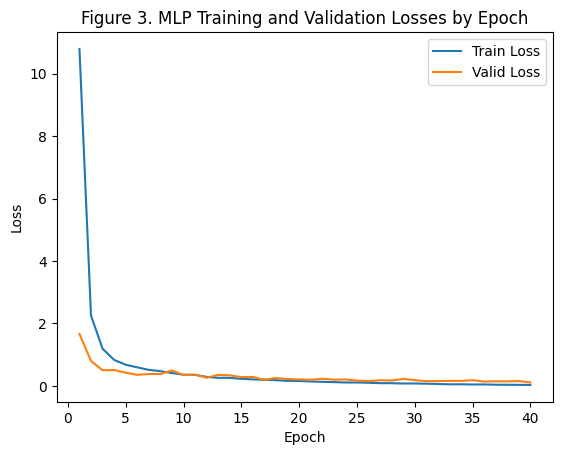

In [35]:
filename = '/content/tar_files/training loss_validation loss_computation_time/gcn1.csv'

res = ReadModelTrainingLog(filename)
plt.plot(res['Epoch'], res[['Train Loss', 'Valid Loss']])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Figure 3. MLP Training and Validation Losses by Epoch')
plt.legend(['Train Loss', 'Valid Loss'])

As illustrated in Figure 3, both training and validation losses show a significant decline initially, followed by a gradual decrease as the number of epochs increases. To investigate potential overfitting, we monitored the validation loss, which did not increase with additional epochs. Early stopping trials at epochs 15, 20, and 25 yielded average MRR of 0.38, 0.42, and 0.45, respectively. The performance at epoch 15 aligns closely with the results reported in the original paper. However, continued improvements beyond epoch 15 suggest that overfitting is unlikely.

### 4.1.2 GCN Model

####4.1.2.1 Model Evaluation

As illustrated in Table 2, baseline GCN models exhibit marginally lower performance compared to MLP models, with the mean rank, MRR, Hits@1, and Hits@10 on the test set all recording lower values for GCNs. The test MRR for GCN models ranges between 0.48 and 0.50.

####4.1.2.2 Losses

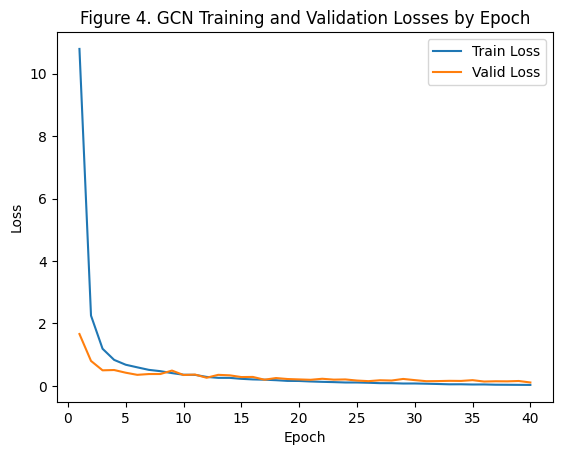

In [36]:
filename = '/content/tar_files/training loss_validation loss_computation_time/gcn1.csv'

res = ReadModelTrainingLog(filename)
plt.plot(res['Epoch'], res[['Train Loss', 'Valid Loss']])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Figure 4. GCN Training and Validation Losses by Epoch')
plt.legend(['Train Loss', 'Valid Loss'])

The loss patterns observed in GCN models are analogous to those in MLP models, characterized by a rapid initial decline followed by a more gradual decrease as the number of epochs increases. Additionally, the validation loss for GCN models also decreases over epochs, albeit at a slower rate compared to the training loss.

## 4.2 Ensembles

### 4.2.1 MLP-ensembles, GCN-ensembles and All-ensembles

In [37]:
import pandas as pd

def ReadModelResult(filename):
    res = pd.read_csv(filename, index_col=0)
    res.columns = [
        'Mean rank',
        'Hits at 1',
        'Hits at 10',
        'Hits at 100',
        'Hits at 500',
        'Hits at 1000',
        'MRR',
    ]
    res.index = [
        'Training',
        'Validation',
        'Test',
    ]
    return res

def GetModelMetricsForTable(metrics, row_name):
    res = metrics.loc[['Training', 'Test'], ['Mean rank', 'MRR', 'Hits at 1', 'Hits at 10']]
    res = res.stack().to_frame().T
    res.columns = ['_'.join(map(str, col)).strip() for col in res.columns.values]
    res.reset_index(drop=True, inplace=True)
    res.index = [row_name]

    return res

In [38]:
def GenerateTable(model_result_file_map):
    table = None
    for model_name, file_name in model_result_file_map.items():
        res = ReadModelResult(file_name)
        metrics = GetModelMetricsForTable(res, model_name)

        if table is None:
            table = metrics
        else:
            table = pd.concat([table, metrics])
    return table

In [39]:
model_result_file_map_1 = {
    'MLP1': '/content/tar_files/model evaluation results/mlp1_eval.csv',
    'MLP2': '/content/tar_files/model evaluation results/mlp2_eval.csv',
    'MLP3': '/content/tar_files/model evaluation results/mlp3_eval.csv',
    'GCN1': '/content/tar_files/model evaluation results/gcn1_eval.csv',
    'GCN2': '/content/tar_files/model evaluation results/gcn2_eval.csv',
    'GCN3': '/content/tar_files/model evaluation results/gcn3_eval.csv',
    'MLP-Ensemble': '/content/tar_files/model evaluation results/ensemble_mlp1_mlp2_mlp3_eval.csv',
    'GCN-Ensemble': '/content/tar_files/model evaluation results/ensemble_gcn1_gcn2_gcn3_eval.csv',
    'All-Emsemble': '/content/tar_files/model evaluation results/ensemble_mlp1_mlp2_mlp3_gcn1_gcn2_gcn3_eval.csv',
}

table1 = GenerateTable(model_result_file_map_1)
display(HTML('<h3>Table 2. Evaluation Results for Single and Ensemble MLP and GCN Models </h3>'))
table1

,Training_Mean rank,Training_MRR,Training_Hits at 1,Training_Hits at 10,Test_Mean rank,Test_MRR,Test_Hits at 1,Test_Hits at 10
MLP1,3.600235,0.607535,0.436118,0.937973,26.676462,0.503714,0.339897,0.835807
MLP2,3.690813,0.599136,0.426386,0.934717,23.529839,0.501113,0.335656,0.837019
MLP3,3.684035,0.604239,0.432975,0.932142,21.966980,0.506720,0.342623,0.830657
GCN1,3.799341,0.597223,0.425250,0.931763,25.867313,0.485722,0.319600,0.820660
GCN2,3.730195,0.602012,0.430513,0.934149,28.821569,0.491767,0.328082,0.826719
GCN3,3.839670,0.597432,0.427901,0.927901,23.491972,0.502044,0.339291,0.827628
MLP-Ensemble,2.885111,0.668012,0.504052,0.963420,18.179037,0.557719,0.392911,0.874281
GCN-Ensemble,3.004998,0.665483,0.503219,0.959596,19.720085,0.553528,0.390488,0.870948
All-Emsemble,2.587928,0.705125,0.553014,0.970426,16.375038,0.592594,0.436534,0.886701


In [40]:
# !gdown "https://drive.google.com/file/d/1euDqte6asdr0SZMff0np8-KBOWWqsfnb/view?usp=drive_link" -O "/content/original.png"

In [41]:
# from IPython.display import Image, display
# print ("Table 3. Evaluation Results for Single and Ensemble MLP and GCN Models From The Original Article")


# Display the image
# display(Image(filename="/content/original.png"))


Table 3. Evaluation Results for Single and Ensemble MLP and GCN Models From The Original Article

![](https://drive.google.com/uc?id=1euDqte6asdr0SZMff0np8-KBOWWqsfnb)

![](https://drive.google.com/open?id=1euDqte6asdr0SZMff0np8-KBOWWqsfnb)

Shown in Table 2, We evaluated that the ensemble of all three MLP models, as well as the ensemble of all three GCN models, both demonstrated improved performance compared to any individual model. Moreover, the all-ensemble configuration, which combines three MLPs and three GCN models, achieved the highest performance metrics, recording a mean rank of 16.38 and an MRR of 0.59 in our study. These findings corroborate the primary assertion in the original article, as documented in Table 3, that ensembles of MLP or GCN models consistently outperform their single-component counterparts, supporting Hypothesis 2.

### 4.2.2 Hybrid Ensembles

In [42]:
def GetValidationMRR(metrics):
    return metrics.loc['Validation', 'MRR']

In [43]:
def GetTestMRR(metrics):
    return metrics.loc['Test', 'MRR']

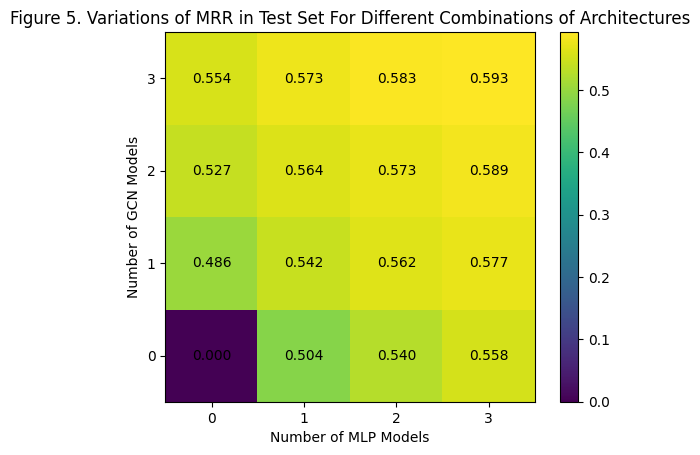

In [44]:
import matplotlib.pyplot as plt

result = np.zeros([4,4])
for mlp_n in range(0,4):
    mlp_s = '_'.join(['mlp'+str(i) for i in range(1, mlp_n+1)])
    for gcn_n in range(0, 4):
        gcn_s = '_'.join(['gcn'+str(i) for i in range(1, gcn_n+1)])

        s = '_'.join([mlp_s, gcn_s]).strip('_')

        if mlp_n == 0 and gcn_n == 0:
            continue
        if mlp_n == 1 and gcn_n == 0:
            file_name = f'mlp1_eval.csv'
        elif mlp_n == 0 and gcn_n == 1:
            file_name = f'gcn1_eval.csv'
        else:
            file_name = f'ensemble_{s}_eval.csv'
        file_name = f'/content/tar_files/model evaluation results/{file_name}'

        res = ReadModelResult(file_name)
        #mrr = GetValidationMRR(res)
        mrr = GetTestMRR(res)

        result[mlp_n, gcn_n] = mrr

im = plt.imshow(result, cmap='viridis')
plt.colorbar(im)
plt.xlabel('Number of MLP Models')
plt.ylabel('Number of GCN Models')
plt.title('Figure 5. Variations of MRR in Test Set For Different Combinations of Architectures')
plt.gca().invert_yaxis()

plt.xticks(np.arange(result.shape[1]), labels=np.arange(result.shape[1]))
plt.yticks(np.arange(result.shape[0]), labels=np.arange(result.shape[0]))

for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        plt.text(i, j, format(result[i, j], '.3f'), ha='center', va='center', color='black')

We further reproduced the advantageous effect of a hybrid ensemble consisting of MLP and GCN models compared to ensembles comprising solely MLP or GCN models. As depicted in Figure 5, the hybrid ensembles, for example, one MLP model and two GCN models, achieved a test MRR of 0.564, surpassing the performance of the ensembles with only three MLPs or GCNs, which posted MRRs of 0.558 and 0.554, respectively. This finding lends additional support to Hypothesis 2, affirming that hybrid ensembles capitalize on the strengths of both model types.

## 4.3  Attention Layer

We extracted the weights of the final layer of the attention model and used it to produce the new assocation rules - denoted by AR(a,b) in the formula below. These new association rules were subsequently integrated with the existing association rules from the MLP model to formulate an updated ranking for the molecule embeddings.

$$
S (a, b) = \alpha cos(a,b) + (1 - \alpha) AR(a,b)
$$

<p align = "center"> (Edwards et al., 2021)

Upon evaluation on the validation set, we found that an alpha value of 0.98 yielded the highest MRR, as depicted in Figure 6. This indicates that the rules generated by the attention model contributed minimally to enhancing the performance of the original MLP model.

Text(0.5, 1.0, 'Figure 6. Validation data MRR for alpha values of [0 - 1]')

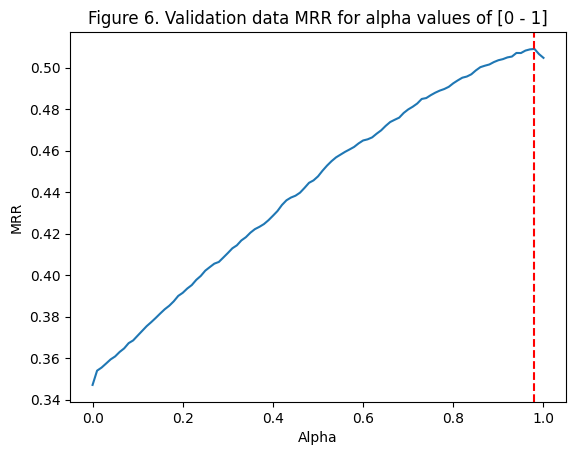

In [45]:
filename = '/content/tar_files/training loss_validation loss_computation_time/mlp_attention.csv'

res = ReadModelTrainingLog(filename)
plt.plot(res['alpha'], res[['MRR']])
plt.xlabel('Alpha')
plt.ylabel('MRR')
plt.axvline(0.98, linestyle='dashed', color='r')
plt.title('Figure 6. Validation data MRR for alpha values of [0 - 1]')


In comparison to MLP1, the incorporation of the attention layer led to a marginal enhancement of 0.05% MRR on the test set. This contrasts with the 0.4% improvement observed in the original paper. Our hypothesis is that this discrepancy arises from the already elevated performance of the MLP1 baseline, stemming from extensive training over 40 epochs. Consequently, the modest gains from the attention layer's generated rules might be limited, as these rules derive from the same dataset.

In [46]:
model_result_file_map_attn = {
    'MLP1': '/content/tar_files/model evaluation results/mlp1_eval.csv',
    'MLP1+Attention': '/content/tar_files/model evaluation results/mlp_attention_eval.csv',
}

table3 = GenerateTable(model_result_file_map_attn)
display(HTML("<h3>Table 3. Evaluation Results for Cross-modal Attention</h3>"))
table3

,Training_Mean rank,Training_MRR,Training_Hits at 1,Training_Hits at 10,Test_Mean rank,Test_MRR,Test_Hits at 1,Test_Hits at 10
MLP1,3.600235,0.607535,0.436118,0.937973,26.676462,0.503714,0.339897,0.835807
MLP1+Attention,NaN,NaN,NaN,NaN,26.677673,0.503767,0.339897,0.835807


## 4.4  Ablation Studies

In [47]:
model_result_file_map_2 = {
    'MLP1': '/content/tar_files/model evaluation results/mlp1_eval.csv',
    'GCN1': '/content/tar_files/model evaluation results/gcn1_eval.csv',
    'Ablation add dropout rate 0.5 MLP': '/content/tar_files/model evaluation results/ablation_add_dropout_rate_0.5_mlp_eval.csv',
    'Ablation max pool GCN': '/content/tar_files/model evaluation results/ablation_max_pool_gcn_eval.csv',
    'Ablation reduce batch size 16 MLP': '/content/tar_files/model evaluation results/ablation_reduce_batch_size_16_mlp_eval.csv',
    'Ablation reduce learning rate MLP': '/content/tar_files/model evaluation results/ablation_reduce_learning_rate_mlp_eval.csv',
    'Ablation remove convolutional layer 2 GCN': '/content/tar_files/model evaluation results/ablation_remove_convolutional_layer_2_gcn_eval.csv',
    'Ablation remove molecule encoder hidden layer 2 MLP': '/content/tar_files/model evaluation results/ablation_remove_molecule_encoder_hidden_layer_2_mlp_eval.csv',
    'Ablation remove nomralization layers MLP': '/content/tar_files/model evaluation results/ablation_remove_normalization_layers_mlp_eval.csv',
    'Ablation change loss function': '/content/tar_files/model evaluation results/ablation_change_loss_function_eval.csv'
}

table4 = GenerateTable(model_result_file_map_2)
display(HTML("<h3>Table 4. Evaluation Results for Ablation Studies</h3>"))
table4

,Training_Mean rank,Training_MRR,Training_Hits at 1,Training_Hits at 10,Test_Mean rank,Test_MRR,Test_Hits at 1,Test_Hits at 10
MLP1,3.600235,0.607535,0.436118,0.937973,26.676462,0.503714,0.339897,0.835807
GCN1,3.799341,0.597223,0.425250,0.931763,25.867313,0.485722,0.319600,0.820660
Ablation add dropout rate 0.5 MLP,4.128749,0.587785,0.417336,0.917374,49.761890,0.461550,0.299606,0.785822
Ablation max pool GCN,4.605877,0.573720,0.407377,0.898364,21.454105,0.493293,0.335959,0.812178
Ablation reduce batch size 16 MLP,4.766169,0.545555,0.374281,0.894464,33.681915,0.466544,0.309603,0.797940
Ablation reduce learning rate MLP,3.980082,0.577631,0.402378,0.923394,29.586792,0.479276,0.316268,0.825507
Ablation remove convolutional layer 2 GCN,3.753219,0.602866,0.434073,0.931990,22.863072,0.489844,0.328688,0.824599
Ablation remove molecule encoder hidden layer 2 MLP,3.732922,0.595614,0.421350,0.932066,29.244774,0.504005,0.342018,0.839746
Ablation remove nomralization layers MLP,7.692442,0.391332,0.216260,0.788965,39.661921,0.332113,0.179643,0.681309
Ablation change loss function,5.269123,0.515234,0.337928,0.883293,37.730688,0.428004,0.266283,0.781884


To assess Hypothesis 1, which posits that all components of the model architectures are essential and that hyperparameters are tuned to achieve optimal performance, such that any modifications would lead to a decline in model efficacy, we designed and conducted comprehensive ablation studies. The results are presented in Table 4.

In terms of model architecture, using the MLP1 model as a baseline, the removal of normalization layers resulted in the most significant performance deterioration, with the Test MRR plummeting from 0.50 to 0.33. Conversely, introducing a dropout rate of 0.5 post-ReLU activation led to a marginal decrease in performance. However, eliminating the middle hidden layer in the molecule encoder did not significantly affect the model's performance. Similarly, removing the middle convolutional layer from the GCN model or substituting mean pooling with max pooling led to slight improvements, with MRR increasing to 0.49.

Regarding hyperparameters, a reduction in batch size from 32 to 16 and halving the learning rate from 1e-4 to 5e-5 both resulted in decreased performance for the MLP model.

For the Symmetric Contrastive Loss Function used in the training of the MLP and GCN models, changing the symmetric loss function to a naive loss function that only accounts for the cross-entropy loss between the text embeddings and the molecule embeddings reduced the performance of the MLP model.

In summary, the ablation studies partially supported Hypothesis 1. Not all components and hyperparameters in the original model configuration were critical to achieving optimal performance, indicating that some elements of the original design could be modified without detrimental effects on overall model effectiveness.

## 4.5 Experiments Beyond The Original Article

### 4.5.1 Ensemble Stategy

In [48]:
model_result_file_map_3 = {
    'MLP1+GCN1': '/content/tar_files/model evaluation results/ensemble_mlp1_gcn1_eval.csv',
    'Ensemble max rank': '/content/tar_files/model evaluation results/additional_experiment_ensemble_max_rank_eval.csv',
    'Ensemble weighted rank average': '/content/tar_files/model evaluation results/additional_experiment_ensemble_weighted_rank_average_eval.csv',
}

table3 = GenerateTable(model_result_file_map_3)
display(HTML("<h3>Table 5. Evaluation Results for Different Ensemble Strategies</h3>"))
table3

,Training_Mean rank,Training_MRR,Training_Hits at 1,Training_Hits at 10,Test_Mean rank,Test_MRR,Test_Hits at 1,Test_Hits at 10
MLP1+GCN1,3.022417,0.656746,0.493297,0.957513,20.670100,0.542279,0.378976,0.865798
Ensemble max rank,3.153173,0.650631,0.488450,0.953347,21.041200,0.537064,0.377461,0.850954
Ensemble weighted rank average,3.600235,0.607535,0.436118,0.937973,26.676462,0.503714,0.339897,0.835807


* Max Rank Ensemble
The Max Rank Ensemble selects the prediction with the highest rank from the individual models.

* Weighted Rank Average Ensemble
The Weighted Rank Average Ensemble calculates the average ranks of model predictions, weighted more heavily towards models with higher MRR.

Shown in Table 5, Both ensemble strategies led to decreased performance compared to the baseline ensemble model, which combines MLP1 and GCN1. This finding partially supports Hypothesis 1, suggesting that the original strategy—integrating mean rank and relative rank sorting—remains the most effective among those evaluated.

### 4.5.2 Text Length

In [49]:
model_result_file_map_3 = {
    'MLP1': '/content/tar_files/model evaluation results/mlp1_eval.csv',
    'MLP1 (Text length > 300)': '/content/tar_files/model evaluation results/additional_experiment_text_length_long_eval.csv',
    'MLP1 (Text length <= 300)': '/content/tar_files/model evaluation results/additional_experiment_text_length_short_eval.csv',
}

table3 = GenerateTable(model_result_file_map_3)
display(HTML("<h3>Table 6. Evaluation Results for Different Text Lengths</h3>"))
table3

,Training_Mean rank,Training_MRR,Training_Hits at 1,Training_Hits at 10,Test_Mean rank,Test_MRR,Test_Hits at 1,Test_Hits at 10
MLP1,3.600235,0.607535,0.436118,0.937973,26.676462,0.503714,0.339897,0.835807
MLP1 (Text length > 300),2.969593,0.639362,0.470781,0.961888,14.507624,0.515332,0.344981,0.860864
MLP1 (Text length <= 300),3.424720,0.612388,0.439361,0.944675,32.261726,0.456647,0.292415,0.785756


* Text Length > 300
Text length > 300 is trained on the data with text descriptions longer than 300

* Text Length <= 300
Text length > 300 is trained on the data with text descriptions shorter or equal to 300

As shpwn in Table 6, longer texts (text length >300) had on par performance with the original MLP model, whereas shorter texts had worse performance. As indicated in Figure 1, 300 is around the median text lengths of the texual descriptions in the original dataset. This suggests that the longer texts model (length > 300) have similar sample sizes to the shorter texts model, and the impact of sample sizes on the model performance is minimal. The worse performance of the shorter texts model is likely because longer descriptions are less noisy and tend to be more informative. (Edwards et al., 2021)

# 5. Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



## 5.1 Reproducibility Assessment

We successfully replicated the findings related to Hypothesis 1 and Hypothesis 2 as reported in the original article. Hypothesis 3 is currently under investigation.

By employing a dose-response investigation and implementing early stopping at epochs 15, 20, and 25, we observed a co-increasing relationship between the number of epochs (less than 40) and model performance. Although our results at epoch 15 align with the original article's performance, further investigation is required to identify factors contributing to the discrepancies observed, aside from the number of epochs.

Our comprehensive and systematic ablation studies revealed that not all components of the model architectures or the hyperparameters proposed in the original article contribute to optimal performance. This observation partially supports Hypothesis 1.

For example, Removing the normalization layer from an MLP model can significantly decrease performance because normalization stabilizes the learning process by reducing internal covariate shift, thereby ensuring that each layer’s inputs have zero mean and unit variance. This not only speeds up training but also helps in maintaining consistent scale across activations, preventing the gradient vanishing or exploding problems that are critical for deep networks. Adding a dropout rate of 0.5 likely reduces model performance because it excessively disables neurons during training, potentially leading to underfitting by preventing the model from learning detailed patterns in the data.

However, the lack of significant performance change upon removing the middle hidden layer in the molecule encoder suggests that this layer might not be critical for capturing the essential features required for the task. This could indicate redundancy within the network architecture, where the remaining layers are capable of compensating for the removed layer's function. Additionally, it may reflect that the model's capacity to encode and process molecular information effectively does not heavily rely on the depth provided by this specific layer. Reducing the batch size from 32 to 16 can lead to decreased performance because smaller batches often provide a less accurate estimate of the gradient. This results in noisier, less stable updates during training, which can hinder convergence to the optimal weights, especially in complex models. Similarly, halving the learning rate from 1e-4 to 5e-5 may cause the learning process to become too slow, potentially failing to converge within the allocated training epochs or getting stuck in suboptimal minima, thereby reducing overall performance.

Our experiments further confirmed that the ensemble strategy consistently outperformed any single model. This improvement can be attributed to the complementary strengths of MLP and GCN models, which excel at different tasks; their combination therefore yields greater benefits. Additionally, the use of relative rank and mean ranking strategies within the ensemble contributed to this enhanced performance. The mean rank with sorting ensemble strategy performs better than weighted rank average or max rank ensemble methods because it provides a robust average that can mitigate the influence of outliers or extreme values from individual model predictions. This approach sorts the predictions first, which ensures that each model's output has a proportional impact, avoiding the dominance of any single model's potentially skewed prediction. In contrast, weighted rank average can overly emphasize models based on their past performance, which might not always be indicative of future accuracy, and max rank can depend too heavily on the single prediction, which might not be consistent across different data points.These findings support Hypothesis 2, affirming that ensemble strategies surpass the effectiveness of individual models.

However, a limitation of our approach is that we did not have sufficient time to conduct all the planned ablation studies and additional experiments, which may have provided further insights into the effectiveness and robustness of different model configurations and ensemble strategies.

## 5.2 What Was Easy

* Re-running the original authors' baseline MLP and GCN code required minimal effort, with only light debugging of `main.py` necessary to get the models operational.
* The ease of execution was significantly aided by the extensive documentation and example runs provided, which facilitated the retrieval and utilization of various model checkpoints.

## 5.3 What Was Difficult

* Implementing the attention mechanism was challenging as the author's provided code was incomplete, particularly lacking components for handling association rules, which is essential for calculating evaluation metrics. Consequently, we had to adapt the code for weight extraction from the original paper, necessitated by recent updates in PyTorch. Additionally, we undertook the task of rewriting the code for the calculation of the evaluation metrics of the model with the incorporation of the new association rules extracted from the attention layer.
* Training the models was considerably time-consuming, with each MLP model training for 4 hours, GCN 8 hours and Attention for over 10 hours.
* The output data was cumbersome to manage since it was not formatted for straightforward storage or analysis, such as in a CSV format, thereby complicating data cleaning and manipulation.

## 5.4 Suggestions To The Author For Improving Reproducibility

* To enhance reproducibility and potentially improve model performance, a deeper analysis of the impacts of various epochs, model architecture components, and hyperparameters is recommended. This approach could uncover additional opportunities for optimization and effectiveness in model design.

* For ease of downstream analysis, it is advisable to standardize the storage of output results in a structured format, such as CSV files. This practice would simplify data handling and enable more straightforward reproducibility and analysis.

* Consider expanding the dataset to include a more diverse and larger sample size with description lengths shorter than 20 words. Adding human-labeled or synthesized data could also improve model robustness and generalization across different datasets and applications.

# 6. References

1.  **Citation to the original paper:**
Edwards, C., Zhai, C., & Ji, H. (2021). Text2Mol: Cross-Modal Molecule Retrieval with Natural Language Queries. In Proceedings of the 2021 Conference on Empirical Methods in Natural Language Processing, 595–607. Online and Punta Cana, Dominican Republic. Association for Computational Linguistics. Data retrieved from: https://aclanthology.org/2021.emnlp-main.47/.

2. **Citation to the original paper’s GitHub repository:**
Edwards, C.(2021). Text2Mol: Cross-Modal Molecule Retrieval with Natural Language Queries. Data retrieved from: https://github.com/cnedwards/text2mol.git.

3. Beltagy, l., Lo, K., & Cohan, A. (2019). SciBERT: A pretrained language model for scientific text. In Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), 3615– 3620. Hong Kong, China. Association for Computational Linguistics. Date retrieved from: https://aclanthology.org/D19-1371/.

4. Rogers, D. & Hahn, M. (2010). Extendedconnectivity fingerprints. Journal of Chemical Information and Modeling, 50(5):742–754. Data retrieved from: https://pubs.acs.org/doi/10.1021/ci100050t.

5. Jaeger, S., Fulle, S. & Turk, S. (2018). Mol2vec: unsupervised machine learning approach with chemical intuition. Journal of chemical information and modeling, 58(1):27–35. Date retrieved from: https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00616.

6. Han, J. & Pei, J. (2000). Mining frequent patterns by pattern-growth: methodology and implications. ACM SIGKDD explorations newsletter, 2(2):14–20. Date retrieved from: https://dl.acm.org/doi/10.1145/380995.381002.


# 7. Appendix



* Model checkpoint output

![](https://drive.google.com/uc?id=1o4pAT0imej9ZBSNGZTqhCzLjo7t0j5qN)

* Figure 1
![](https://drive.google.com/uc?id=1kUKdvfUpeKFjHxJH6PwJf6kS9auo7UMl)

* Figure 2
![](https://drive.google.com/uc?id=14x__vjANi_o7RoOMCecXFDgx_WrdhcTu)

* Figure 3

![](https://drive.google.com/uc?id=1qLMTR15ms3aU4egNdE7twq_Bqm3aueee)

* Figure 4

![](https://drive.google.com/uc?id=1eICmM7z2HYmUn53rte7BS9m-BllTt4sq)

* Figure 5
![](https://drive.google.com/uc?id=1jABkaZwkr1D1I9M4s2zLu8KrlXhMMSVB)

* Table 1

![](https://drive.google.com/uc?id=1lCE0FeZm6lZUBT3gA0z4YBSO9MqY8eNd)

* Table 2

![](https://drive.google.com/uc?id=1RpJ1Vzh3JFUwU1TC2dmzuY1c7pL0pYHi)

* Table 4
![](https://drive.google.com/uc?id=15V71cKTrhIctYbtChg-wJZTX331qlV2R)

* Table 5
![](https://drive.google.com/uc?id=12XSjnAYPEKuNJ5eI9j4xhtt39VsKsh9Z)